# README

This notebook includes label cleaning as well as the training and evaluation of the CMSF models. GPU runtime is required

# Setup

In [ ]:
#GPU runtime required, should give CUDA version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp -r /content/gdrive/MyDrive/Explainable_Wound_Classification/CMSF/semi_supervised/util.py /content
!cp -r /content/gdrive/MyDrive/Explainable_Wound_Classification/CMSF/semi_supervised/tools.py /content
!cp -r /content/gdrive/MyDrive/Explainable_Wound_Classification/RISE/* /content
root_path = 'gdrive/MyDrive/Explainable_Wound_Classification/'

In [ ]:
!pip install faiss-gpu
!pip install fuzzy-c-means

# to use later version of matplotlib (needed for aggregate perturbation visualization but conflicts with some other visualizations), uncomment this line and run the cell, then restart the runtime and run again
#!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import builtins
import os
import sys
import time
import argparse
import random
import copy
from collections import Counter, OrderedDict
from random import shuffle

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets, models

from PIL import ImageFilter, Image
from util import adjust_learning_rate, AverageMeter as AvgMeter, subset_classes, AverageMeterV2

import pdb
import faiss
from fcmeans import FCM

import numpy as np
from numpy import float64
from scipy import stats
import pandas as pd
import re
from collections import namedtuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

import shutil
import warnings

import torch.nn.parallel
import torch.optim
import torch.utils.data
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from tools import *

from skimage.segmentation import mark_boundaries
import matplotlib.cm as mpl_color_map

from tqdm import tqdm
from utils import *
from explanations import RISE

#from skimage import io
from skimage import filters
from skimage import feature
from skimage.util import random_noise

In [ ]:
mpl.__version__

'3.5.2'

# Cleaning Labels

This section cleans the hard labels so they are chronologically consistent for one wound and saves the output to Cleaned_Wound_Stage_Labels.csv

### Setup

In [ ]:
labels_df = pd.read_csv(root_path + 'Updated_Cropped_Images_Wound_Stage_Probabilities.csv', index_col='Image')
labels_df['label'] = labels_df.index.map(lambda x: labels_df.loc[x].argmax())

props = labels_df.index.map(lambda x: re.match('^Day (\d+)_(.+?).png', x).groups())
labels_df['Day'] = props.map(lambda x: int(x[0]))
labels_df['Wound'] = props.map(lambda x: x[1])

labels_df.head()

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 8_A8-4-L.png     0.181818      0.090909       0.545455    0.181818      2   
Day 4_A8-3-R.png     0.090909      0.909091       0.000000    0.000000      1   
Day 14_Y8-4-L.png    0.000000      0.000000       0.090909    0.909091      3   
Day 7_Y8-4-L.png     0.000000      0.000000       0.454545    0.545455      3   
Day 2_A8-1-L.png     0.181818      0.727273       0.090909    0.000000      1   

                   Day   Wound  
Image                           
Day 8_A8-4-L.png     8  A8-4-L  
Day 4_A8-3-R.png     4  A8-3-R  
Day 14_Y8-4-L.png   14  Y8-4-L  
Day 7_Y8-4-L.png     7  Y8-4-L  
Day 2_A8-1-L.png     2  A8-1-L

In [ ]:
wounds = labels_df['Wound'].unique()
wounds

array(['A8-4-L', 'A8-3-R', 'Y8-4-L', 'A8-1-L', 'A8-1-R', 'A8-5-L',
       'Y8-3-L', 'Y8-1-R', 'A8-4-R', 'Y8-2-R', 'Y8-3-R', 'A8-5-R',
       'Y8-1-L', 'Y8-2-L', 'A8-3-L', 'Y8-4-R'], dtype=object)

In [ ]:
# get all labels for a given wound index
def get_labels_df(wound_index):
    return labels_df[labels_df.Wound == wounds[wound_index]].sort_values('Day')

In [ ]:
def show_img(image_name):
    cv2_imshow(cv2.imread(root_path + 'Circle_Cropped_images/' + image_name))

### Inspecting and Modifying LAbels

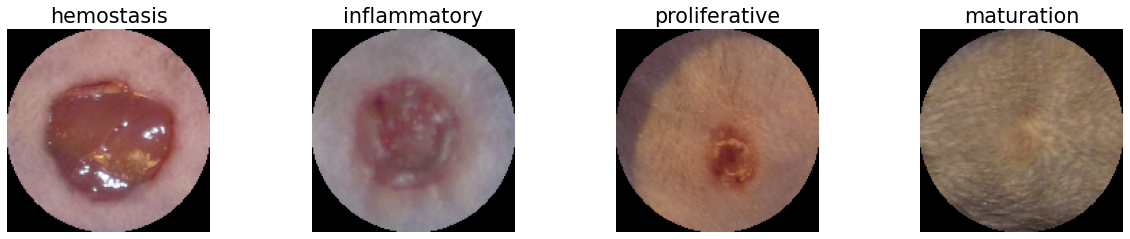

In [ ]:
class_name = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']
images = ['Day 0_Y8-2-R.png', 'Day 4_Y8-2-R.png', 'Day 6_Y8-2-R.png', 'Day 10_Y8-2-R.png']

#fig, axs = plt.subplots(1, 4, figsize=(16,5.5))
fig, axs = plt.subplots(1, 4, figsize=(20,5))
for image_name, ax in zip(images, axs):
    img = Image.open(root_path + 'Circle_Cropped_images/' + image_name)
    ax.axis('off')
    ax.imshow(img)
    soft_label = np.array(labels_df.loc[image_name, ['hemostasis','inflammatory','proliferative','maturation']], dtype=float64)
    #ax.set_title(image_name + '\n\nSoft Label: ' + np.array2string(soft_label, precision=2, floatmode='fixed') + '\nHard Label: ' + class_name[soft_label.argmax()] + '\nCleaned Label: ' + ('proliferative' if image_name == 'Day 9_A8-4-L.png' else class_name[soft_label.argmax()]), fontsize='x-large')
    ax.set_title(class_name[soft_label.argmax()], fontsize='x-large')
#fig.suptitle('After Cleaning', fontsize=18)
fig.subplots_adjust(wspace=0.5)

In [ ]:
get_labels_df(0)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_A8-4-L.png     1.000000      0.000000       0.000000    0.000000      0   
Day 1_A8-4-L.png     0.900000      0.100000       0.000000    0.000000      0   
Day 2_A8-4-L.png     0.800000      0.200000       0.000000    0.000000      0   
Day 3_A8-4-L.png     0.100000      0.800000       0.100000    0.000000      1   
Day 4_A8-4-L.png     0.100000      0.700000       0.200000    0.000000      1   
Day 5_A8-4-L.png     0.000000      0.590000       0.410000    0.000000      1   
Day 6_A8-4-L.png     0.200000      0.600000       0.200000    0.000000      1   
Day 7_A8-4-L.png     0.200000      0.500000       0.300000    0.000000      1   
Day 8_A8-4-L.png     0.181818      0.090909       0.545455    0.181818      2   
Day 9_A8-4-L.png     0.200000      0.500000       0.300000    0.000000      1   
Day 10_A8-4-L.png    0.100000      0.300000       0.600000    0.000000      2   
Day 11_A8-4-L.png    0.000000      0.100000       0.700000    0.200000      2   
Day 12_A8-4-L.png    0.000000      0.100000       0.700000    0.200000      2   
Day 13_A8-4-L.png    0.000000      0.000000       0.272727    0.727273      3   
Day 14_A8-4-L.png    0.000000      0.200000       0.000000    0.800000      3   
Day 15_A8-4-L.png    0.000000      0.000000       0.100000    0.900000      3   

                   Day   Wound  
Image                           
Day 0_A8-4-L.png     0  A8-4-L  
Day 1_A8-4-L.png     1  A8-4-L  
Day 2_A8-4-L.png     2  A8-4-L  
Day 3_A8-4-L.png     3  A8-4-L  
Day 4_A8-4-L.png     4  A8-4-L  
Day 5_A8-4-L.png     5  A8-4-L  
Day 6_A8-4-L.png     6  A8-4-L  
Day 7_A8-4-L.png     7  A8-4-L  
Day 8_A8-4-L.png     8  A8-4-L  
Day 9_A8-4-L.png     9  A8-4-L  
Day 10_A8-4-L.png   10  A8-4-L  
Day 11_A8-4-L.png   11  A8-4-L  
Day 12_A8-4-L.png   12  A8-4-L  
Day 13_A8-4-L.png   13  A8-4-L  
Day 14_A8-4-L.png   14  A8-4-L  
Day 15_A8-4-L.png   15  A8-4-L

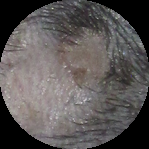

In [ ]:
show_img('Day 15_A8-4-L.png')

In [ ]:
labels_df.loc['Day 9_A8-4-L.png', 'label'] = 2

In [ ]:
get_labels_df(1)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_A8-3-R.png     0.600000      0.400000       0.000000         0.0      0   
Day 1_A8-3-R.png     0.800000      0.200000       0.000000         0.0      0   
Day 2_A8-3-R.png     0.700000      0.300000       0.000000         0.0      0   
Day 3_A8-3-R.png     0.300000      0.600000       0.100000         0.0      1   
Day 4_A8-3-R.png     0.090909      0.909091       0.000000         0.0      1   
Day 5_A8-3-R.png     0.200000      0.700000       0.100000         0.0      1   
Day 6_A8-3-R.png     0.100000      0.800000       0.100000         0.0      1   
Day 7_A8-3-R.png     0.000000      0.420000       0.580000         0.0      2   
Day 8_A8-3-R.png     0.000000      0.200000       0.800000         0.0      2   
Day 9_A8-3-R.png     0.000000      0.090909       0.909091         0.0      2   
Day 10_A8-3-R.png    0.000000      0.100000       0.700000         0.2      2   
Day 11_A8-3-R.png    0.000000      0.300000       0.700000         0.0      2   
Day 12_A8-3-R.png    0.100000      0.200000       0.500000         0.2      2   
Day 13_A8-3-R.png    0.000000      0.000000       0.800000         0.2      2   
Day 14_A8-3-R.png    0.000000      0.000000       0.400000         0.6      3   
Day 15_A8-3-R.png    0.000000      0.000000       0.600000         0.4      2   

                   Day   Wound  
Image                           
Day 0_A8-3-R.png     0  A8-3-R  
Day 1_A8-3-R.png     1  A8-3-R  
Day 2_A8-3-R.png     2  A8-3-R  
Day 3_A8-3-R.png     3  A8-3-R  
Day 4_A8-3-R.png     4  A8-3-R  
Day 5_A8-3-R.png     5  A8-3-R  
Day 6_A8-3-R.png     6  A8-3-R  
Day 7_A8-3-R.png     7  A8-3-R  
Day 8_A8-3-R.png     8  A8-3-R  
Day 9_A8-3-R.png     9  A8-3-R  
Day 10_A8-3-R.png   10  A8-3-R  
Day 11_A8-3-R.png   11  A8-3-R  
Day 12_A8-3-R.png   12  A8-3-R  
Day 13_A8-3-R.png   13  A8-3-R  
Day 14_A8-3-R.png   14  A8-3-R  
Day 15_A8-3-R.png   15  A8-3-R

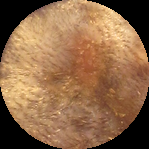

In [ ]:
show_img('Day 14_A8-3-R.png')

In [ ]:
labels_df.loc['Day 15_A8-3-R.png', 'label'] = 3

In [ ]:
get_labels_df(2)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_Y8-4-L.png         1.00          0.00       0.000000    0.000000      0   
Day 1_Y8-4-L.png         0.57          0.43       0.000000    0.000000      0   
Day 2_Y8-4-L.png         0.80          0.20       0.000000    0.000000      0   
Day 3_Y8-4-L.png         0.20          0.80       0.000000    0.000000      1   
Day 4_Y8-4-L.png         0.40          0.50       0.100000    0.000000      1   
Day 5_Y8-4-L.png         0.30          0.50       0.200000    0.000000      1   
Day 6_Y8-4-L.png         0.10          0.30       0.600000    0.000000      2   
Day 7_Y8-4-L.png         0.00          0.00       0.454545    0.545455      3   
Day 8_Y8-4-L.png         0.00          0.00       0.600000    0.400000      2   
Day 9_Y8-4-L.png         0.00          0.00       0.600000    0.400000      2   
Day 10_Y8-4-L.png        0.00          0.00       0.100000    0.900000      3   
Day 11_Y8-4-L.png        0.00          0.00       0.000000    1.000000      3   
Day 12_Y8-4-L.png        0.00          0.00       0.100000    0.900000      3   
Day 13_Y8-4-L.png        0.00          0.00       0.000000    1.000000      3   
Day 14_Y8-4-L.png        0.00          0.00       0.090909    0.909091      3   
Day 15_Y8-4-L.png        0.00          0.00       0.000000    1.000000      3   

                   Day   Wound  
Image                           
Day 0_Y8-4-L.png     0  Y8-4-L  
Day 1_Y8-4-L.png     1  Y8-4-L  
Day 2_Y8-4-L.png     2  Y8-4-L  
Day 3_Y8-4-L.png     3  Y8-4-L  
Day 4_Y8-4-L.png     4  Y8-4-L  
Day 5_Y8-4-L.png     5  Y8-4-L  
Day 6_Y8-4-L.png     6  Y8-4-L  
Day 7_Y8-4-L.png     7  Y8-4-L  
Day 8_Y8-4-L.png     8  Y8-4-L  
Day 9_Y8-4-L.png     9  Y8-4-L  
Day 10_Y8-4-L.png   10  Y8-4-L  
Day 11_Y8-4-L.png   11  Y8-4-L  
Day 12_Y8-4-L.png   12  Y8-4-L  
Day 13_Y8-4-L.png   13  Y8-4-L  
Day 14_Y8-4-L.png   14  Y8-4-L  
Day 15_Y8-4-L.png   15  Y8-4-L

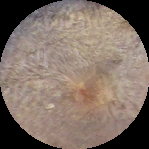

In [ ]:
show_img('Day 10_Y8-4-L.png')

In [ ]:
labels_df.loc['Day 7_Y8-4-L.png', 'label'] = 2

In [ ]:
get_labels_df(3)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_A8-1-L.png     0.600000      0.200000       0.200000    0.000000      0   
Day 1_A8-1-L.png     0.900000      0.100000       0.000000    0.000000      0   
Day 2_A8-1-L.png     0.181818      0.727273       0.090909    0.000000      1   
Day 3_A8-1-L.png     0.300000      0.700000       0.000000    0.000000      1   
Day 4_A8-1-L.png     0.100000      0.400000       0.500000    0.000000      2   
Day 5_A8-1-L.png     0.000000      0.200000       0.800000    0.000000      2   
Day 6_A8-1-L.png     0.200000      0.400000       0.400000    0.000000      1   
Day 7_A8-1-L.png     0.300000      0.200000       0.500000    0.000000      2   
Day 8_A8-1-L.png     0.300000      0.100000       0.600000    0.000000      2   
Day 9_A8-1-L.png     0.000000      0.300000       0.600000    0.100000      2   
Day 10_A8-1-L.png    0.000000      0.300000       0.700000    0.000000      2   
Day 11_A8-1-L.png    0.000000      0.000000       0.636364    0.363636      2   
Day 12_A8-1-L.png    0.100000      0.200000       0.600000    0.100000      2   
Day 13_A8-1-L.png    0.000000      0.200000       0.500000    0.300000      2   
Day 14_A8-1-L.png    0.000000      0.000000       0.666667    0.333333      2   
Day 15_A8-1-L.png    0.000000      0.000000       0.100000    0.900000      3   

                   Day   Wound  
Image                           
Day 0_A8-1-L.png     0  A8-1-L  
Day 1_A8-1-L.png     1  A8-1-L  
Day 2_A8-1-L.png     2  A8-1-L  
Day 3_A8-1-L.png     3  A8-1-L  
Day 4_A8-1-L.png     4  A8-1-L  
Day 5_A8-1-L.png     5  A8-1-L  
Day 6_A8-1-L.png     6  A8-1-L  
Day 7_A8-1-L.png     7  A8-1-L  
Day 8_A8-1-L.png     8  A8-1-L  
Day 9_A8-1-L.png     9  A8-1-L  
Day 10_A8-1-L.png   10  A8-1-L  
Day 11_A8-1-L.png   11  A8-1-L  
Day 12_A8-1-L.png   12  A8-1-L  
Day 13_A8-1-L.png   13  A8-1-L  
Day 14_A8-1-L.png   14  A8-1-L  
Day 15_A8-1-L.png   15  A8-1-L

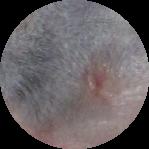

In [ ]:
show_img('Day 15_A8-1-L.png')

In [ ]:
labels_df.loc['Day 6_A8-1-L.png', 'label'] = 2

In [ ]:
get_labels_df(4)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_A8-1-R.png     0.900000      0.100000       0.000000         0.0      0   
Day 1_A8-1-R.png     0.100000      0.800000       0.100000         0.0      1   
Day 2_A8-1-R.png     0.400000      0.500000       0.100000         0.0      1   
Day 3_A8-1-R.png     0.400000      0.500000       0.100000         0.0      1   
Day 4_A8-1-R.png     0.363636      0.636364       0.000000         0.0      1   
Day 5_A8-1-R.png     0.200000      0.500000       0.300000         0.0      1   
Day 6_A8-1-R.png     0.200000      0.700000       0.100000         0.0      1   
Day 7_A8-1-R.png     0.100000      0.700000       0.100000         0.1      1   
Day 8_A8-1-R.png     0.200000      0.600000       0.200000         0.0      1   
Day 9_A8-1-R.png     0.090909      0.454545       0.454545         0.0      1   
Day 10_A8-1-R.png    0.100000      0.400000       0.500000         0.0      2   
Day 11_A8-1-R.png    0.000000      0.100000       0.800000         0.1      2   
Day 12_A8-1-R.png    0.000000      0.200000       0.500000         0.3      2   
Day 13_A8-1-R.png    0.000000      0.100000       0.500000         0.4      2   
Day 14_A8-1-R.png    0.000000      0.100000       0.300000         0.6      3   
Day 15_A8-1-R.png    0.000000      0.100000       0.600000         0.3      2   

                   Day   Wound  
Image                           
Day 0_A8-1-R.png     0  A8-1-R  
Day 1_A8-1-R.png     1  A8-1-R  
Day 2_A8-1-R.png     2  A8-1-R  
Day 3_A8-1-R.png     3  A8-1-R  
Day 4_A8-1-R.png     4  A8-1-R  
Day 5_A8-1-R.png     5  A8-1-R  
Day 6_A8-1-R.png     6  A8-1-R  
Day 7_A8-1-R.png     7  A8-1-R  
Day 8_A8-1-R.png     8  A8-1-R  
Day 9_A8-1-R.png     9  A8-1-R  
Day 10_A8-1-R.png   10  A8-1-R  
Day 11_A8-1-R.png   11  A8-1-R  
Day 12_A8-1-R.png   12  A8-1-R  
Day 13_A8-1-R.png   13  A8-1-R  
Day 14_A8-1-R.png   14  A8-1-R  
Day 15_A8-1-R.png   15  A8-1-R

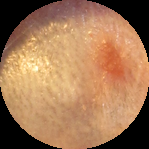

In [ ]:
show_img('Day 14_A8-1-R.png')

In [ ]:
#labels_df.loc['Day 9_A8-1-R.png', 'label'] = 2
labels_df.loc['Day 15_A8-1-R.png', 'label'] = 3

In [ ]:
get_labels_df(5)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_A8-5-L.png          0.8      0.200000       0.000000    0.000000      0   
Day 1_A8-5-L.png          0.6      0.300000       0.100000    0.000000      0   
Day 2_A8-5-L.png          0.9      0.100000       0.000000    0.000000      0   
Day 3_A8-5-L.png          0.2      0.800000       0.000000    0.000000      1   
Day 4_A8-5-L.png          0.2      0.300000       0.500000    0.000000      2   
Day 5_A8-5-L.png          0.1      0.500000       0.400000    0.000000      1   
Day 6_A8-5-L.png          0.1      0.500000       0.400000    0.000000      1   
Day 7_A8-5-L.png          0.0      0.000000       0.909091    0.090909      2   
Day 8_A8-5-L.png          0.0      0.400000       0.600000    0.000000      2   
Day 9_A8-5-L.png          0.0      0.300000       0.200000    0.500000      3   
Day 10_A8-5-L.png         0.0      0.200000       0.700000    0.100000      2   
Day 11_A8-5-L.png         0.0      0.000000       0.600000    0.400000      2   
Day 12_A8-5-L.png         0.0      0.000000       0.800000    0.200000      2   
Day 13_A8-5-L.png         0.0      0.100000       0.600000    0.300000      2   
Day 14_A8-5-L.png         0.0      0.090909       0.490000    0.510000      3   
Day 15_A8-5-L.png         0.0      0.100000       0.600000    0.300000      2   

                   Day   Wound  
Image                           
Day 0_A8-5-L.png     0  A8-5-L  
Day 1_A8-5-L.png     1  A8-5-L  
Day 2_A8-5-L.png     2  A8-5-L  
Day 3_A8-5-L.png     3  A8-5-L  
Day 4_A8-5-L.png     4  A8-5-L  
Day 5_A8-5-L.png     5  A8-5-L  
Day 6_A8-5-L.png     6  A8-5-L  
Day 7_A8-5-L.png     7  A8-5-L  
Day 8_A8-5-L.png     8  A8-5-L  
Day 9_A8-5-L.png     9  A8-5-L  
Day 10_A8-5-L.png   10  A8-5-L  
Day 11_A8-5-L.png   11  A8-5-L  
Day 12_A8-5-L.png   12  A8-5-L  
Day 13_A8-5-L.png   13  A8-5-L  
Day 14_A8-5-L.png   14  A8-5-L  
Day 15_A8-5-L.png   15  A8-5-L

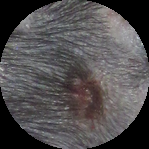

In [ ]:
show_img('Day 15_A8-5-L.png')

In [ ]:
labels_df.loc['Day 4_A8-5-L.png', 'label'] = 1
labels_df.loc['Day 9_A8-5-L.png', 'label'] = 2
labels_df.loc['Day 15_A8-5-L.png', 'label'] = 3

In [ ]:
get_labels_df(6)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_Y8-3-L.png     0.727273      0.272727            0.0         0.0      0   
Day 1_Y8-3-L.png     0.700000      0.300000            0.0         0.0      0   
Day 2_Y8-3-L.png     0.700000      0.300000            0.0         0.0      0   
Day 3_Y8-3-L.png     0.400000      0.500000            0.1         0.0      1   
Day 4_Y8-3-L.png     0.300000      0.600000            0.1         0.0      1   
Day 5_Y8-3-L.png     0.200000      0.400000            0.4         0.0      1   
Day 6_Y8-3-L.png     0.100000      0.300000            0.6         0.0      2   
Day 7_Y8-3-L.png     0.000000      0.200000            0.7         0.1      2   
Day 8_Y8-3-L.png     0.000000      0.100000            0.6         0.3      2   
Day 9_Y8-3-L.png     0.100000      0.100000            0.7         0.1      2   
Day 10_Y8-3-L.png    0.000000      0.000000            0.1         0.9      3   
Day 11_Y8-3-L.png    0.000000      0.000000            0.2         0.8      3   
Day 12_Y8-3-L.png    0.000000      0.000000            0.2         0.8      3   
Day 13_Y8-3-L.png    0.000000      0.000000            0.0         1.0      3   
Day 14_Y8-3-L.png    0.000000      0.000000            0.1         0.9      3   
Day 15_Y8-3-L.png    0.000000      0.000000            0.0         1.0      3   

                   Day   Wound  
Image                           
Day 0_Y8-3-L.png     0  Y8-3-L  
Day 1_Y8-3-L.png     1  Y8-3-L  
Day 2_Y8-3-L.png     2  Y8-3-L  
Day 3_Y8-3-L.png     3  Y8-3-L  
Day 4_Y8-3-L.png     4  Y8-3-L  
Day 5_Y8-3-L.png     5  Y8-3-L  
Day 6_Y8-3-L.png     6  Y8-3-L  
Day 7_Y8-3-L.png     7  Y8-3-L  
Day 8_Y8-3-L.png     8  Y8-3-L  
Day 9_Y8-3-L.png     9  Y8-3-L  
Day 10_Y8-3-L.png   10  Y8-3-L  
Day 11_Y8-3-L.png   11  Y8-3-L  
Day 12_Y8-3-L.png   12  Y8-3-L  
Day 13_Y8-3-L.png   13  Y8-3-L  
Day 14_Y8-3-L.png   14  Y8-3-L  
Day 15_Y8-3-L.png   15  Y8-3-L

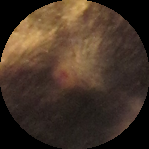

In [ ]:
show_img('Day 14_Y8-3-L.png')

In [ ]:
get_labels_df(7)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_Y8-1-R.png          0.8          0.20       0.000000    0.000000      0   
Day 1_Y8-1-R.png          0.7          0.30       0.000000    0.000000      0   
Day 2_Y8-1-R.png          0.7          0.30       0.000000    0.000000      0   
Day 3_Y8-1-R.png          0.4          0.60       0.000000    0.000000      1   
Day 4_Y8-1-R.png          0.2          0.70       0.100000    0.000000      1   
Day 5_Y8-1-R.png          0.1          0.50       0.400000    0.000000      1   
Day 6_Y8-1-R.png          0.0          0.51       0.490000    0.000000      1   
Day 7_Y8-1-R.png          0.0          0.30       0.500000    0.200000      2   
Day 8_Y8-1-R.png          0.0          0.10       0.800000    0.100000      2   
Day 9_Y8-1-R.png          0.0          0.00       0.600000    0.400000      2   
Day 10_Y8-1-R.png         0.0          0.10       0.300000    0.600000      3   
Day 11_Y8-1-R.png         0.0          0.00       0.000000    1.000000      3   
Day 12_Y8-1-R.png         0.0          0.00       0.000000    1.000000      3   
Day 13_Y8-1-R.png         0.0          0.00       0.000000    1.000000      3   
Day 14_Y8-1-R.png         0.0          0.00       0.100000    0.900000      3   
Day 15_Y8-1-R.png         0.0          0.00       0.090909    0.909091      3   

                   Day   Wound  
Image                           
Day 0_Y8-1-R.png     0  Y8-1-R  
Day 1_Y8-1-R.png     1  Y8-1-R  
Day 2_Y8-1-R.png     2  Y8-1-R  
Day 3_Y8-1-R.png     3  Y8-1-R  
Day 4_Y8-1-R.png     4  Y8-1-R  
Day 5_Y8-1-R.png     5  Y8-1-R  
Day 6_Y8-1-R.png     6  Y8-1-R  
Day 7_Y8-1-R.png     7  Y8-1-R  
Day 8_Y8-1-R.png     8  Y8-1-R  
Day 9_Y8-1-R.png     9  Y8-1-R  
Day 10_Y8-1-R.png   10  Y8-1-R  
Day 11_Y8-1-R.png   11  Y8-1-R  
Day 12_Y8-1-R.png   12  Y8-1-R  
Day 13_Y8-1-R.png   13  Y8-1-R  
Day 14_Y8-1-R.png   14  Y8-1-R  
Day 15_Y8-1-R.png   15  Y8-1-R

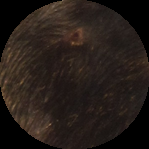

In [ ]:
show_img('Day 14_Y8-1-R.png')

In [ ]:
get_labels_df(8)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_A8-4-R.png     1.000000      0.000000       0.000000    0.000000      0   
Day 1_A8-4-R.png     0.800000      0.200000       0.000000    0.000000      0   
Day 2_A8-4-R.png     0.900000      0.100000       0.000000    0.000000      0   
Day 3_A8-4-R.png     0.909091      0.090909       0.000000    0.000000      0   
Day 4_A8-4-R.png     0.200000      0.500000       0.300000    0.000000      1   
Day 5_A8-4-R.png     0.100000      0.700000       0.200000    0.000000      1   
Day 6_A8-4-R.png     0.500000      0.400000       0.100000    0.000000      0   
Day 7_A8-4-R.png     0.100000      0.700000       0.200000    0.000000      1   
Day 8_A8-4-R.png     0.000000      0.400000       0.500000    0.100000      2   
Day 9_A8-4-R.png     0.000000      0.100000       0.800000    0.100000      2   
Day 10_A8-4-R.png    0.000000      0.090909       0.727273    0.181818      2   
Day 11_A8-4-R.png    0.000000      0.200000       0.700000    0.100000      2   
Day 12_A8-4-R.png    0.000000      0.000000       0.600000    0.400000      2   
Day 13_A8-4-R.png    0.000000      0.400000       0.500000    0.100000      2   
Day 14_A8-4-R.png    0.000000      0.111111       0.777778    0.111111      2   
Day 15_A8-4-R.png    0.000000      0.000000       0.100000    0.900000      3   

                   Day   Wound  
Image                           
Day 0_A8-4-R.png     0  A8-4-R  
Day 1_A8-4-R.png     1  A8-4-R  
Day 2_A8-4-R.png     2  A8-4-R  
Day 3_A8-4-R.png     3  A8-4-R  
Day 4_A8-4-R.png     4  A8-4-R  
Day 5_A8-4-R.png     5  A8-4-R  
Day 6_A8-4-R.png     6  A8-4-R  
Day 7_A8-4-R.png     7  A8-4-R  
Day 8_A8-4-R.png     8  A8-4-R  
Day 9_A8-4-R.png     9  A8-4-R  
Day 10_A8-4-R.png   10  A8-4-R  
Day 11_A8-4-R.png   11  A8-4-R  
Day 12_A8-4-R.png   12  A8-4-R  
Day 13_A8-4-R.png   13  A8-4-R  
Day 14_A8-4-R.png   14  A8-4-R  
Day 15_A8-4-R.png   15  A8-4-R

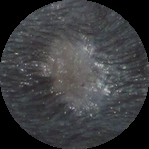

In [ ]:
show_img('Day 15_A8-4-R.png')

In [ ]:
labels_df.loc['Day 6_A8-4-R.png', 'label'] = 1

In [ ]:
get_labels_df(9)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_Y8-2-R.png     1.000000      0.000000       0.000000         0.0      0   
Day 1_Y8-2-R.png     0.800000      0.200000       0.000000         0.0      0   
Day 2_Y8-2-R.png     0.400000      0.600000       0.000000         0.0      1   
Day 3_Y8-2-R.png     0.600000      0.300000       0.100000         0.0      0   
Day 4_Y8-2-R.png     0.181818      0.545455       0.272727         0.0      1   
Day 5_Y8-2-R.png     0.000000      0.200000       0.800000         0.0      2   
Day 6_Y8-2-R.png     0.000000      0.100000       0.700000         0.2      2   
Day 7_Y8-2-R.png     0.000000      0.000000       0.800000         0.2      2   
Day 8_Y8-2-R.png     0.000000      0.000000       0.700000         0.3      2   
Day 10_Y8-2-R.png    0.000000      0.000000       0.000000         1.0      3   
Day 11_Y8-2-R.png    0.000000      0.000000       0.000000         1.0      3   
Day 12_Y8-2-R.png    0.000000      0.000000       0.000000         1.0      3   
Day 13_Y8-2-R.png    0.000000      0.000000       0.000000         1.0      3   
Day 14_Y8-2-R.png    0.000000      0.000000       0.000000         1.0      3   
Day 15_Y8-2-R.png    0.000000      0.000000       0.000000         1.0      3   

                   Day   Wound  
Image                           
Day 0_Y8-2-R.png     0  Y8-2-R  
Day 1_Y8-2-R.png     1  Y8-2-R  
Day 2_Y8-2-R.png     2  Y8-2-R  
Day 3_Y8-2-R.png     3  Y8-2-R  
Day 4_Y8-2-R.png     4  Y8-2-R  
Day 5_Y8-2-R.png     5  Y8-2-R  
Day 6_Y8-2-R.png     6  Y8-2-R  
Day 7_Y8-2-R.png     7  Y8-2-R  
Day 8_Y8-2-R.png     8  Y8-2-R  
Day 10_Y8-2-R.png   10  Y8-2-R  
Day 11_Y8-2-R.png   11  Y8-2-R  
Day 12_Y8-2-R.png   12  Y8-2-R  
Day 13_Y8-2-R.png   13  Y8-2-R  
Day 14_Y8-2-R.png   14  Y8-2-R  
Day 15_Y8-2-R.png   15  Y8-2-R

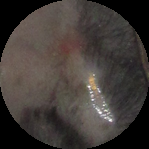

In [ ]:
show_img('Day 12_Y8-3-R.png')

In [ ]:
labels_df.loc['Day 3_Y8-2-R.png', 'label'] = 1

In [ ]:
get_labels_df(10)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_Y8-3-R.png     1.000000      0.000000       0.000000    0.000000      0   
Day 1_Y8-3-R.png     0.800000      0.200000       0.000000    0.000000      0   
Day 2_Y8-3-R.png     0.900000      0.100000       0.000000    0.000000      0   
Day 3_Y8-3-R.png     0.636364      0.272727       0.090909    0.000000      0   
Day 4_Y8-3-R.png     0.600000      0.400000       0.000000    0.000000      0   
Day 5_Y8-3-R.png     0.100000      0.700000       0.200000    0.000000      1   
Day 6_Y8-3-R.png     0.090909      0.181818       0.727273    0.000000      2   
Day 7_Y8-3-R.png     0.100000      0.100000       0.700000    0.100000      2   
Day 8_Y8-3-R.png     0.000000      0.000000       0.600000    0.400000      2   
Day 9_Y8-3-R.png     0.000000      0.000000       0.600000    0.400000      2   
Day 10_Y8-3-R.png    0.000000      0.000000       0.090909    0.909091      3   
Day 11_Y8-3-R.png    0.000000      0.000000       0.100000    0.900000      3   
Day 12_Y8-3-R.png    0.000000      0.000000       0.100000    0.900000      3   
Day 13_Y8-3-R.png    0.000000      0.000000       0.000000    1.000000      3   
Day 14_Y8-3-R.png    0.000000      0.000000       0.000000    1.000000      3   
Day 15_Y8-3-R.png    0.000000      0.000000       0.000000    1.000000      3   

                   Day   Wound  
Image                           
Day 0_Y8-3-R.png     0  Y8-3-R  
Day 1_Y8-3-R.png     1  Y8-3-R  
Day 2_Y8-3-R.png     2  Y8-3-R  
Day 3_Y8-3-R.png     3  Y8-3-R  
Day 4_Y8-3-R.png     4  Y8-3-R  
Day 5_Y8-3-R.png     5  Y8-3-R  
Day 6_Y8-3-R.png     6  Y8-3-R  
Day 7_Y8-3-R.png     7  Y8-3-R  
Day 8_Y8-3-R.png     8  Y8-3-R  
Day 9_Y8-3-R.png     9  Y8-3-R  
Day 10_Y8-3-R.png   10  Y8-3-R  
Day 11_Y8-3-R.png   11  Y8-3-R  
Day 12_Y8-3-R.png   12  Y8-3-R  
Day 13_Y8-3-R.png   13  Y8-3-R  
Day 14_Y8-3-R.png   14  Y8-3-R  
Day 15_Y8-3-R.png   15  Y8-3-R

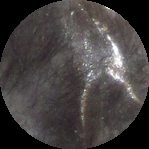

In [ ]:
show_img('Day 13_A8-5-R.png')

In [ ]:
get_labels_df(11)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_A8-5-R.png     0.800000      0.200000       0.000000    0.000000      0   
Day 1_A8-5-R.png     0.545455      0.454545       0.000000    0.000000      0   
Day 2_A8-5-R.png     0.600000      0.400000       0.000000    0.000000      0   
Day 3_A8-5-R.png     0.200000      0.600000       0.200000    0.000000      1   
Day 4_A8-5-R.png     0.000000      0.363636       0.636364    0.000000      2   
Day 5_A8-5-R.png     0.000000      0.500000       0.500000    0.000000      1   
Day 6_A8-5-R.png     0.100000      0.400000       0.500000    0.000000      2   
Day 7_A8-5-R.png     0.000000      0.400000       0.600000    0.000000      2   
Day 8_A8-5-R.png     0.100000      0.100000       0.700000    0.100000      2   
Day 9_A8-5-R.png     0.000000      0.000000       0.400000    0.600000      3   
Day 10_A8-5-R.png    0.000000      0.000000       0.600000    0.400000      2   
Day 11_A8-5-R.png    0.000000      0.000000       0.400000    0.600000      3   
Day 12_A8-5-R.png    0.090909      0.000000       0.000000    0.909091      3   
Day 13_A8-5-R.png    0.000000      0.000000       0.222222    0.777778      3   
Day 14_A8-5-R.png    0.000000      0.000000       0.200000    0.800000      3   
Day 15_A8-5-R.png    0.000000      0.000000       0.100000    0.900000      3   

                   Day   Wound  
Image                           
Day 0_A8-5-R.png     0  A8-5-R  
Day 1_A8-5-R.png     1  A8-5-R  
Day 2_A8-5-R.png     2  A8-5-R  
Day 3_A8-5-R.png     3  A8-5-R  
Day 4_A8-5-R.png     4  A8-5-R  
Day 5_A8-5-R.png     5  A8-5-R  
Day 6_A8-5-R.png     6  A8-5-R  
Day 7_A8-5-R.png     7  A8-5-R  
Day 8_A8-5-R.png     8  A8-5-R  
Day 9_A8-5-R.png     9  A8-5-R  
Day 10_A8-5-R.png   10  A8-5-R  
Day 11_A8-5-R.png   11  A8-5-R  
Day 12_A8-5-R.png   12  A8-5-R  
Day 13_A8-5-R.png   13  A8-5-R  
Day 14_A8-5-R.png   14  A8-5-R  
Day 15_A8-5-R.png   15  A8-5-R

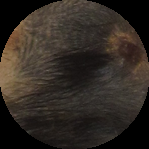

In [ ]:
show_img('Day 11_Y8-1-L.png')

In [ ]:
labels_df.loc['Day 5_A8-5-R.png', 'label'] = 2
labels_df.loc['Day 10_A8-5-R.png', 'label'] = 3

In [ ]:
get_labels_df(12)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_Y8-1-L.png     0.727273      0.272727       0.000000    0.000000      0   
Day 1_Y8-1-L.png     0.700000      0.300000       0.000000    0.000000      0   
Day 2_Y8-1-L.png     0.800000      0.200000       0.000000    0.000000      0   
Day 3_Y8-1-L.png     0.400000      0.500000       0.100000    0.000000      1   
Day 4_Y8-1-L.png     0.300000      0.500000       0.200000    0.000000      1   
Day 5_Y8-1-L.png     0.363636      0.545455       0.090909    0.000000      1   
Day 6_Y8-1-L.png     0.000000      0.600000       0.400000    0.000000      1   
Day 7_Y8-1-L.png     0.100000      0.200000       0.700000    0.000000      2   
Day 8_Y8-1-L.png     0.000000      0.100000       0.900000    0.000000      2   
Day 9_Y8-1-L.png     0.000000      0.200000       0.640000    0.160000      2   
Day 10_Y8-1-L.png    0.000000      0.100000       0.800000    0.100000      2   
Day 11_Y8-1-L.png    0.000000      0.000000       0.100000    0.900000      3   
Day 12_Y8-1-L.png    0.000000      0.000000       0.000000    1.000000      3   
Day 13_Y8-1-L.png    0.000000      0.000000       0.181818    0.818182      3   
Day 14_Y8-1-L.png    0.000000      0.000000       0.000000    1.000000      3   
Day 15_Y8-1-L.png    0.000000      0.000000       0.000000    1.000000      3   

                   Day   Wound  
Image                           
Day 0_Y8-1-L.png     0  Y8-1-L  
Day 1_Y8-1-L.png     1  Y8-1-L  
Day 2_Y8-1-L.png     2  Y8-1-L  
Day 3_Y8-1-L.png     3  Y8-1-L  
Day 4_Y8-1-L.png     4  Y8-1-L  
Day 5_Y8-1-L.png     5  Y8-1-L  
Day 6_Y8-1-L.png     6  Y8-1-L  
Day 7_Y8-1-L.png     7  Y8-1-L  
Day 8_Y8-1-L.png     8  Y8-1-L  
Day 9_Y8-1-L.png     9  Y8-1-L  
Day 10_Y8-1-L.png   10  Y8-1-L  
Day 11_Y8-1-L.png   11  Y8-1-L  
Day 12_Y8-1-L.png   12  Y8-1-L  
Day 13_Y8-1-L.png   13  Y8-1-L  
Day 14_Y8-1-L.png   14  Y8-1-L  
Day 15_Y8-1-L.png   15  Y8-1-L

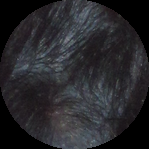

In [ ]:
show_img('Day 13_Y8-2-L.png')

In [ ]:
get_labels_df(13)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_Y8-2-L.png     0.900000      0.100000       0.000000    0.000000      0   
Day 1_Y8-2-L.png     1.000000      0.000000       0.000000    0.000000      0   
Day 2_Y8-2-L.png     0.727273      0.272727       0.000000    0.000000      0   
Day 3_Y8-2-L.png     0.800000      0.200000       0.000000    0.000000      0   
Day 4_Y8-2-L.png     0.700000      0.300000       0.000000    0.000000      0   
Day 5_Y8-2-L.png     0.100000      0.400000       0.500000    0.000000      2   
Day 6_Y8-2-L.png     0.100000      0.600000       0.300000    0.000000      1   
Day 7_Y8-2-L.png     0.090909      0.545455       0.363636    0.000000      1   
Day 8_Y8-2-L.png     0.100000      0.400000       0.500000    0.000000      2   
Day 9_Y8-2-L.png     0.100000      0.500000       0.300000    0.100000      1   
Day 10_Y8-2-L.png    0.000000      0.200000       0.700000    0.100000      2   
Day 11_Y8-2-L.png    0.000000      0.000000       0.454545    0.545455      3   
Day 12_Y8-2-L.png    0.000000      0.000000       0.400000    0.600000      3   
Day 13_Y8-2-L.png    0.000000      0.000000       0.000000    1.000000      3   
Day 14_Y8-2-L.png    0.000000      0.000000       0.090909    0.909091      3   
Day 15_Y8-2-L.png    0.000000      0.000000       0.100000    0.900000      3   

                   Day   Wound  
Image                           
Day 0_Y8-2-L.png     0  Y8-2-L  
Day 1_Y8-2-L.png     1  Y8-2-L  
Day 2_Y8-2-L.png     2  Y8-2-L  
Day 3_Y8-2-L.png     3  Y8-2-L  
Day 4_Y8-2-L.png     4  Y8-2-L  
Day 5_Y8-2-L.png     5  Y8-2-L  
Day 6_Y8-2-L.png     6  Y8-2-L  
Day 7_Y8-2-L.png     7  Y8-2-L  
Day 8_Y8-2-L.png     8  Y8-2-L  
Day 9_Y8-2-L.png     9  Y8-2-L  
Day 10_Y8-2-L.png   10  Y8-2-L  
Day 11_Y8-2-L.png   11  Y8-2-L  
Day 12_Y8-2-L.png   12  Y8-2-L  
Day 13_Y8-2-L.png   13  Y8-2-L  
Day 14_Y8-2-L.png   14  Y8-2-L  
Day 15_Y8-2-L.png   15  Y8-2-L

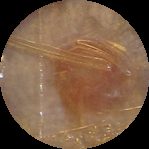

In [ ]:
show_img('Day 9_A8-3-L.png')

In [ ]:
labels_df.loc['Day 5_Y8-2-L.png', 'label'] = 1
labels_df.loc['Day 9_Y8-2-L.png', 'label'] = 2

In [ ]:
get_labels_df(14)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_A8-3-L.png     0.700000      0.200000       0.100000         0.0      0   
Day 1_A8-3-L.png     0.800000      0.200000       0.000000         0.0      0   
Day 2_A8-3-L.png     0.545455      0.454545       0.000000         0.0      0   
Day 3_A8-3-L.png     0.200000      0.700000       0.000000         0.1      1   
Day 4_A8-3-L.png     0.300000      0.600000       0.100000         0.0      1   
Day 5_A8-3-L.png     0.200000      0.700000       0.100000         0.0      1   
Day 6_A8-3-L.png     0.200000      0.600000       0.200000         0.0      1   
Day 7_A8-3-L.png     0.100000      0.100000       0.800000         0.0      2   
Day 8_A8-3-L.png     0.000000      0.600000       0.400000         0.0      1   
Day 9_A8-3-L.png     0.100000      0.300000       0.600000         0.0      2   
Day 10_A8-3-L.png    0.000000      0.300000       0.700000         0.0      2   
Day 11_A8-3-L.png    0.090909      0.090909       0.818182         0.0      2   
Day 12_A8-3-L.png    0.000000      0.100000       0.700000         0.2      2   
Day 13_A8-3-L.png    0.000000      0.100000       0.700000         0.2      2   
Day 14_A8-3-L.png    0.000000      0.000000       0.600000         0.4      2   
Day 15_A8-3-L.png    0.000000      0.000000       0.600000         0.4      2   

                   Day   Wound  
Image                           
Day 0_A8-3-L.png     0  A8-3-L  
Day 1_A8-3-L.png     1  A8-3-L  
Day 2_A8-3-L.png     2  A8-3-L  
Day 3_A8-3-L.png     3  A8-3-L  
Day 4_A8-3-L.png     4  A8-3-L  
Day 5_A8-3-L.png     5  A8-3-L  
Day 6_A8-3-L.png     6  A8-3-L  
Day 7_A8-3-L.png     7  A8-3-L  
Day 8_A8-3-L.png     8  A8-3-L  
Day 9_A8-3-L.png     9  A8-3-L  
Day 10_A8-3-L.png   10  A8-3-L  
Day 11_A8-3-L.png   11  A8-3-L  
Day 12_A8-3-L.png   12  A8-3-L  
Day 13_A8-3-L.png   13  A8-3-L  
Day 14_A8-3-L.png   14  A8-3-L  
Day 15_A8-3-L.png   15  A8-3-L

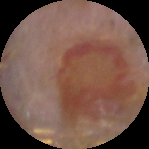

In [ ]:
show_img('Day 8_A8-3-L.png')

In [ ]:
labels_df.loc['Day 8_A8-3-L.png', 'label'] = 2

In [ ]:
get_labels_df(15)

hemostasis  inflammatory  proliferative  maturation  label  \
Image                                                                           
Day 0_Y8-4-R.png     1.000000      0.000000       0.000000         0.0      0   
Day 1_Y8-4-R.png     0.181818      0.272727       0.545455         0.0      2   
Day 2_Y8-4-R.png     0.300000      0.700000       0.000000         0.0      1   
Day 3_Y8-4-R.png     0.300000      0.700000       0.000000         0.0      1   
Day 4_Y8-4-R.png     0.090909      0.363636       0.545455         0.0      2   
Day 5_Y8-4-R.png     0.000000      0.200000       0.800000         0.0      2   
Day 6_Y8-4-R.png     0.000000      0.300000       0.700000         0.0      2   
Day 7_Y8-4-R.png     0.000000      0.000000       0.600000         0.4      2   
Day 8_Y8-4-R.png     0.100000      0.000000       0.800000         0.1      2   
Day 9_Y8-4-R.png     0.000000      0.000000       0.600000         0.4      2   
Day 10_Y8-4-R.png    0.000000      0.000000       0.400000         0.6      3   
Day 11_Y8-4-R.png    0.000000      0.000000       0.400000         0.6      3   
Day 12_Y8-4-R.png    0.000000      0.000000       0.000000         1.0      3   
Day 13_Y8-4-R.png    0.000000      0.000000       0.000000         1.0      3   
Day 14_Y8-4-R.png    0.000000      0.000000       0.000000         1.0      3   
Day 15_Y8-4-R.png    0.000000      0.000000       0.000000         1.0      3   

                   Day   Wound  
Image                           
Day 0_Y8-4-R.png     0  Y8-4-R  
Day 1_Y8-4-R.png     1  Y8-4-R  
Day 2_Y8-4-R.png     2  Y8-4-R  
Day 3_Y8-4-R.png     3  Y8-4-R  
Day 4_Y8-4-R.png     4  Y8-4-R  
Day 5_Y8-4-R.png     5  Y8-4-R  
Day 6_Y8-4-R.png     6  Y8-4-R  
Day 7_Y8-4-R.png     7  Y8-4-R  
Day 8_Y8-4-R.png     8  Y8-4-R  
Day 9_Y8-4-R.png     9  Y8-4-R  
Day 10_Y8-4-R.png   10  Y8-4-R  
Day 11_Y8-4-R.png   11  Y8-4-R  
Day 12_Y8-4-R.png   12  Y8-4-R  
Day 13_Y8-4-R.png   13  Y8-4-R  
Day 14_Y8-4-R.png   14  Y8-4-R  
Day 15_Y8-4-R.png   15  Y8-4-R

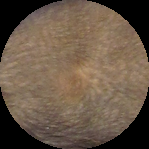

In [ ]:
show_img('Day 10_Y8-2-R.png')

In [ ]:
labels_df.loc['Day 1_Y8-4-R.png', 'label'] = 1

### Review and Saving

In [ ]:
# ensure all labels are non-decreasing as day increases
# shouldn't print anything
for wound_ind in range(len(wounds)):
    labels = get_labels_df(wound_ind)['label']
    prev_label = labels[0]
    for label_ind in range(1, len(labels)):
        if labels[label_ind] < prev_label:
            print(labels.index[label_ind])
        prev_label = labels[label_ind]

In [ ]:
cleaned_df = labels_df[['hemostasis','inflammatory','proliferative','maturation','label']]
cleaned_df.head()

hemostasis  inflammatory  proliferative  maturation  label
Image                                                                        
Day 8_A8-4-L.png     0.181818      0.090909       0.545455    0.181818      2
Day 4_A8-3-R.png     0.090909      0.909091       0.000000    0.000000      1
Day 14_Y8-4-L.png    0.000000      0.000000       0.090909    0.909091      3
Day 7_Y8-4-L.png     0.000000      0.000000       0.454545    0.545455      2
Day 2_A8-1-L.png     0.181818      0.727273       0.090909    0.000000      1

In [ ]:
cleaned_df.to_csv(root_path + 'Cleaned_Wound_Stage_Labels.csv')

#Self-Supervised CMSF

Mostly modified from https://github.com/UMBCvision/CMSF/blob/main/self_supervised/train_msf_km.py

### Misc Functions

In [ ]:
def get_mlp(inp_dim, hidden_dim, out_dim):
    mlp = nn.Sequential(
        nn.Linear(inp_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, out_dim),
    )
    return mlp

In [ ]:
def set_parameter_requires_grad(model, requires_grad=False):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [ ]:
def faiss_kmeans(feats, nmb_clusters):
    feats = feats.numpy()
    d = feats.shape[-1]
    clus = faiss.Clustering(d, nmb_clusters)
    clus.niter = 20
    clus.max_points_per_centroid = 10000000

    index = faiss.IndexFlatL2(d)
    co = faiss.GpuMultipleClonerOptions()
    co.useFloat16 = True
    co.shard = True
    index = faiss.index_cpu_to_all_gpus(index, co)

    # perform the training
    clus.train(feats, index)
    _, train_a = index.search(feats, 1)

    return list(train_a[:, 0])

In [ ]:
def fuzzy_c_means(feats, nmb_clusters):
    feats = feats.numpy()
    
    fcm = FCM(n_clusters=nmb_clusters)
    fcm.fit(feats)

    return fcm.predict(feats), fcm

In [ ]:
def get_shuffle_ids(bsz):
    """generate shuffle ids for ShuffleBN"""
    forward_inds = torch.randperm(bsz).long().cuda()
    backward_inds = torch.zeros(bsz).long().cuda()
    value = torch.arange(bsz).long().cuda()
    backward_inds.index_copy_(0, forward_inds, value)
    return forward_inds, backward_inds


### Model Architecture

In [ ]:
# HealNet Encoder
class Encoder(nn.Module):
    """
    Encoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(Encoder, self).__init__() 
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])
        # 7x7 average pool layer
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        # Left image connected layers
        self.fc_16 = nn.Linear(1024, 16)


    def forward(self, x):
        # Embed Left
        u1 = self.embed_model(x)
        u1 = self.avg(u1)
        u1 = u1.view(-1,1024)
        u1 = self.fc_16(u1)
        #u1 = torch.relu(u1)
        return u1

In [ ]:
# Healnet ecnoder with resnet
class ResnetEncoder(nn.Module):
    """
    ResnetEncoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(ResnetEncoder, self).__init__() 
        # Initialize resnet18
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # Classification Layer
        num_ftrs = self.embed_model.fc.in_features
        self.embed_model.fc = nn.Linear(num_ftrs, 16)
        self.fc = self.embed_model.fc


    def forward(self, x):
        # Embed Left
        return self.embed_model(x)

In [ ]:
def initialize_encoder(model_name, output_dim, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, output_dim)
        input_size = 224

    elif model_name == "healnet":
        """ Pretrained Encoder from HealNet
        """
        model_ft = Encoder()
        model_ft.load_state_dict(torch.load(root_path + 'trained_encoder_weights.tar'))
        set_parameter_requires_grad(model_ft)
        set_parameter_requires_grad(model_ft.fc_16, requires_grad=True)
        input_size = 224
    
    elif model_name == "resnet_healnet":
        """ Pretrained Encoder from HealNet
        """
        model_ft = ResnetEncoder()
        model_ft.load_state_dict(torch.load(root_path + 'resnet_healnet_encoder_weights.tar'))
        set_parameter_requires_grad(model_ft)
        set_parameter_requires_grad(model_ft.fc, requires_grad=True)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,output_dim)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,output_dim)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        model_ft.classifier[1] = nn.Conv2d(512, output_dim, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = output_dim
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, output_dim)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, output_dim)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,output_dim)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
class ConstrainedMeanShiftKM(nn.Module):
    def __init__(self, arch, m=0.99, mem_bank_size=128000, topk=5, dataset_size=100, num_clusters=4, output_dim=16):
        super(ConstrainedMeanShiftKM, self).__init__()

        # save parameters
        self.m = m
        self.mem_bank_size = mem_bank_size
        self.topk = topk
        self.dataset_size = dataset_size
        self.num_clusters = num_clusters

        # create encoders and projection layers
        # both encoders should have same arch
        self.encoder_q = initialize_encoder(arch, output_dim)[0]
        self.encoder_t = initialize_encoder(arch, output_dim)[0]

        # prediction layer
        self.predict_q = get_mlp(output_dim, output_dim * 2, output_dim)

        # copy query encoder weights to target encoder
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data.copy_(param_q.data)
            param_t.requires_grad = False

        print("using mem-bank size {}".format(self.mem_bank_size))
        # setup queue (For Storing Random Targets)
        self.register_buffer('queue', torch.randn(self.mem_bank_size, output_dim))
        self.register_buffer('pool', torch.randn(self.dataset_size, output_dim))
        self.register_buffer('pseudo_labels', 0*torch.ones(self.dataset_size).long())
        # normalize the queue embeddings
        self.queue = nn.functional.normalize(self.queue, dim=1)
        # initialize the labels queue (For Purity measurement)
        self.register_buffer('labels', -1*torch.ones(self.mem_bank_size).long())
        self.register_buffer('index_queue', -1 * torch.ones(self.mem_bank_size).long())
        # setup the queue pointer
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_target_encoder(self):
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data = param_t.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def data_parallel(self):
        self.encoder_q = torch.nn.DataParallel(self.encoder_q)
        self.encoder_t = torch.nn.DataParallel(self.encoder_t)
        self.predict_q = torch.nn.DataParallel(self.predict_q)

    @torch.no_grad()
    def cluster(self):
        print('start clustering ... num clusters: {}'.format(self.num_clusters))
        cluster_assignment, cluster_model = fuzzy_c_means(self.pool.clone().cpu(), self.num_clusters)
        self.pseudo_labels = torch.tensor(cluster_assignment).cuda()
        return cluster_model

    @torch.no_grad()
    def _dequeue_and_enqueue(self, targets, labels, indices):
        batch_size = targets.shape[0]

        ptr = int(self.queue_ptr)
        assert self.mem_bank_size % batch_size == 0 

        # replace the targets at ptr (dequeue and enqueue)
        self.pool[indices, :] = targets
        self.queue[ptr:ptr + batch_size] = targets
        self.labels[ptr:ptr + batch_size] = labels
        self.index_queue[ptr:ptr + batch_size] = indices
        ptr = (ptr + batch_size) % self.mem_bank_size  # move pointer

        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_t, labels, indices):
        # compute query features
        feat_q = self.encoder_q(im_q)
        # compute predictions for instance level regression loss
        query = self.predict_q(feat_q)
        query = nn.functional.normalize(query, dim=1)

        # compute target features
        with torch.no_grad():
            # update the target encoder
            self._momentum_update_target_encoder()

            # shuffle targets
            shuffle_ids, reverse_ids = get_shuffle_ids(im_t.shape[0])
            im_t = im_t[shuffle_ids]

            # forward through the target encoder
            current_target = self.encoder_t(im_t)
            current_target = nn.functional.normalize(current_target, dim=1)

            # undo shuffle
            current_target = current_target[reverse_ids].detach()

            # update the memory-bank
            self._dequeue_and_enqueue(current_target, labels, indices)

        targets = self.queue.clone().detach()

        # get pseudo of target and memory bank samples
        current_target_pseudo_labels = self.pseudo_labels[indices]
        targets_pseudo_labels = self.pseudo_labels[self.index_queue]

        # create a mask to constrain the search space
        b = current_target_pseudo_labels.shape[0]
        m = targets_pseudo_labels.shape[0]
        lx = current_target_pseudo_labels.unsqueeze(1).expand((b, m))
        lm = targets_pseudo_labels.unsqueeze(0).expand((b, m))
        msk = lx != lm

        # calculate distances between vectors
        dist_t = 2 - 2 * torch.einsum('bc,kc->bk', [current_target, targets])
        dist_q = 2 - 2 * torch.einsum('bc,kc->bk', [query, targets])

        # select the k nearest neighbors [with smallest distance (largest=False)] based on current target
        _, unconstrained_nn_index = dist_t.topk(self.topk, dim=1, largest=False)

        # select the k nearest neighbors based on constrained memory bank
        dist_t[torch.where(msk)] = 5.0
        _, constrained_nn_index = dist_t.topk(self.topk, dim=1, largest=False)

        # calculate mean shift regression loss
        nn_dist_q_constrained = torch.gather(dist_q, 1, constrained_nn_index)
        nn_dist_q_unconstrained = torch.gather(dist_q, 1, unconstrained_nn_index)

        # purity based on memory bank
        labels = labels.unsqueeze(1).expand(nn_dist_q_unconstrained.shape[0], nn_dist_q_unconstrained.shape[1])
        labels_queue = self.labels.clone().detach()
        labels_queue = labels_queue.unsqueeze(0).expand((nn_dist_q_unconstrained.shape[0], self.mem_bank_size))
        labels_queue = torch.gather(labels_queue, dim=1, index=unconstrained_nn_index)
# TODO: Change matches here
        matches = (labels_queue == labels).float()
        purity = (matches.sum(dim=1) / self.topk).mean()

        loss = ((nn_dist_q_constrained.sum(dim=1) / self.topk).mean()
                + (nn_dist_q_unconstrained.sum(dim=1) / self.topk).mean()) / 2.0

        return loss, purity

### Transformations/Data Loading

In [ ]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and target."""
    def __init__(self, weak_transform, strong_transform):
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        print(self.weak_transform)
        print(self.strong_transform)

    def __call__(self, x):
        q = self.strong_transform(x)
        t = self.weak_transform(x)
        return [q, t]


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [ ]:
class Image_Dataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, label_fn, transform=None):
        """
        Image dataset. Returns tensorized images and labels with index
        Args:
            root_dir: path to a cropped mouse image dataset.
            label_fn: function that returns the correct label given an image name
        """
        self.root_dir = root_dir
        self.label_fn = label_fn
        self.transform = transform

        samples = []
        targets = []
        for f in os.listdir(root_dir):
            samples.append(os.path.join(root_dir, f))
            targets.append(label_fn(f))
        
        self.samples = samples
        self.targets = targets

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
            """
            Returns index, tensor data, and tensorized label.
            """
            img = self.pil_loader(self.samples[index])
            target = self.targets[index]

            if self.transform:
                img = self.transform(img)

            return index, img, torch.tensor(target)

    def __len__(self):
        return len(self.samples)

    def __str__(self):
        return "Image_Dataset:\n" + "Found " + str(len(self)) + " images in " + self.root_dir + "\n"

In [ ]:
# Create train loader
def get_train_loader(datapath, label_fn, batch_size, num_workers, weak_strong=True):
    traindir = os.path.join(datapath, 'train')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)

    augmentation_strong = [
        transforms.RandomResizedCrop(224, scale=(0.5, 1.)),
        #transforms.Resize(224),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        #transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(saturation=(0,1)),
        transforms.RandomRotation((0, 360)),
        #transforms.RandomAffine((0,0), translate=(0.3, 0.3)),
        transforms.ToTensor(),
        normalize
    ]

    augmentation_weak = [
        transforms.RandomResizedCrop(224, scale=(0.5, 1.)),
        #transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((0, 360)),
        transforms.ToTensor(),
        normalize,
    ]

    if weak_strong:
        train_dataset = Image_Dataset(
            traindir, label_fn, 
            TwoCropsTransform(transforms.Compose(augmentation_weak), transforms.Compose(augmentation_strong))
        )
    else:
        train_dataset = Image_Dataset(
            traindir, label_fn, 
            TwoCropsTransform(transforms.Compose(augmentation_weak), transforms.Compose(augmentation_weak))
        )

    print('==> train dataset')
    print(train_dataset)

    # NOTE: remove drop_last
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True)

    return train_loader

In [ ]:
def get_val_loader(datapath, label_fn, num_workers, batch_size=-1, test=False, train=False):
    if test:
        valdir = os.path.join(datapath, 'test')
    elif train:
        valdir = os.path.join(datapath, 'train')
    else:
        valdir = os.path.join(datapath, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    val_transform = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = Image_Dataset(valdir, label_fn, val_transform)

    if batch_size == -1:
        batch_size = len(dataset)

    val_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True,
    )
    return val_loader, dataset.samples

### Training Functions

In [ ]:
def train(epoch, train_loader, mean_shift, optimizer, print_freq):
    """
    one epoch training
    """
    mean_shift.train()

    batch_time = AvgMeter()
    data_time = AvgMeter()
    loss_meter = AvgMeter()
    purity_meter = AvgMeter()

    end = time.time()
    for idx, (indices, (im_q, im_t), labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        im_q = im_q.cuda(non_blocking=True)
        im_t = im_t.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        # ===================forward=====================
        loss, purity = mean_shift(im_q=im_q, im_t=im_t, labels=labels, indices=indices)

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        loss_meter.update(loss.item(), im_q.size(0))
        purity_meter.update(purity.item(), im_q.size(0))

        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'purity {purity.val:.3f} ({purity.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time,
                   purity=purity_meter,
                   loss=loss_meter))
            sys.stdout.flush()
            sys.stdout.flush()

    

    return loss_meter.avg, purity_meter.avg

In [ ]:
#workaround struct to pass args to util script
LRArgs = namedtuple('LRArgs', ['cos', 'learning_rate', 'epochs', 'lr_decay_rate'])

In [ ]:
def cmsf_km_main(data_path, checkpoint_path, label_fn, batch_size=16, num_workers=2, 
                 epochs=200, print_freq=10, save_freq=10, weak_strong=True, 
                 debug=False, arch='resnet50', momentum=0.99, mem_bank_size=128000, 
                 topk=5, num_clusters=4, learning_rate=0.05, sgd_momentum=0.9, 
                 weight_decay=1e-4, weights=None, resume=None, cos=True, 
                 lr_decay_rate=0.2, output_dim=16):
    """
    todo: docstring
    """
    opt = locals()
    del opt['label_fn']

    if (not resume):
        os.makedirs(checkpoint_path)

    train_loader = get_train_loader(data_path, label_fn, batch_size, num_workers, weak_strong)

    mean_shift = ConstrainedMeanShiftKM(
        arch,
        m=momentum,
        mem_bank_size=mem_bank_size,
        topk=topk,
        dataset_size=len(train_loader.dataset),
        num_clusters=num_clusters,
        output_dim=output_dim
    )

    mean_shift.data_parallel()
    mean_shift = mean_shift.cuda()
    print(mean_shift)


    print("Params to learn:")
    for name,param in mean_shift.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    params = [p for p in mean_shift.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params,
                                lr=learning_rate,
                                momentum=sgd_momentum,
                                weight_decay=weight_decay)

    cudnn.benchmark = True
    start_epoch = 1

    history_df = pd.DataFrame(index=range(start_epoch, epochs + 1))

    if weights:
        print('==> load weights from checkpoint: {}'.format(weights))
        ckpt = torch.load(weights)
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        if 'model' in ckpt:
            sd = ckpt['model']
        else:
            sd = ckpt['state_dict']
        msg = mean_shift.load_state_dict(sd, strict=False)
        optimizer.load_state_dict(ckpt['optimizer'])
        start_epoch = ckpt['epoch'] + 1
        print(msg)
    

    if resume:
        print('==> resume from checkpoint: {}'.format(resume))
        ckpt = torch.load(resume, map_location='cpu')
        # sd = ckpt['state_dict']
        # sd = {k.replace('module.', ''): v for k, v in sd.items()}
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        mean_shift.load_state_dict(ckpt['state_dict'], strict=True)
        optimizer.load_state_dict(ckpt['optimizer'])
        start_epoch = ckpt['epoch'] + 1
        history_df = ckpt['history_df']

    lr_args = LRArgs(cos, learning_rate, epochs, lr_decay_rate)

    for epoch in range(start_epoch, epochs + 1):

        adjust_learning_rate(epoch, lr_args, optimizer)
        print("==> training...")

        time1 = time.time()

        loss, purity = train(epoch, train_loader, mean_shift, optimizer, print_freq)
        cluster_model = mean_shift.cluster()

        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        history_df.loc[epoch, 'loss'] = loss
        history_df.loc[epoch, 'purity'] = purity

        # saving the model
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'opt': opt,
                'state_dict': mean_shift.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'history_df': history_df
            }

            save_file = os.path.join(checkpoint_path, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

            # help release GPU memory
            del state
            torch.cuda.empty_cache()

### Getting Label Assignments

In [ ]:
labels_df = pd.read_csv(root_path + 'Cleaned_Wound_Stage_Labels.csv', index_col='Image')
labels_df.head()

hemostasis  inflammatory  proliferative  maturation  label
Image                                                                        
Day 8_A8-4-L.png     0.181818      0.090909       0.545455    0.181818      2
Day 4_A8-3-R.png     0.090909      0.909091       0.000000    0.000000      1
Day 14_Y8-4-L.png    0.000000      0.000000       0.090909    0.909091      3
Day 7_Y8-4-L.png     0.000000      0.000000       0.454545    0.545455      2
Day 2_A8-1-L.png     0.181818      0.727273       0.090909    0.000000      1

In [ ]:
#labels_df['label'] = labels_df.index.map(lambda x: labels_df.loc[x].argmax())
#labels_df.head()

In [ ]:
labels_map = labels_df['label']
labels_map.head()

Image
Day 8_A8-4-L.png     2
Day 4_A8-3-R.png     1
Day 14_Y8-4-L.png    3
Day 7_Y8-4-L.png     2
Day 2_A8-1-L.png     1
Name: label, dtype: int64

### Folder to store outputs and number of epochs to run

In [ ]:
train_folder_name = 'unsupervised_finals/1_ww/'
epochs = 200

# Self-Supervised Training

Edit the last cell in the section above to control the output folder and number of epochs

### Training

In [ ]:
cmsf_km_main(
    data_path=root_path + 'Split_images', 
    checkpoint_path=root_path + 'outputs/' + train_folder_name, 
    label_fn=lambda x: labels_map[x],
    num_workers=2,
    epochs=epochs,
    arch='resnet_healnet',
    batch_size=8,
    num_clusters=4,
    learning_rate=0.05,
    mem_bank_size=128000,
    topk=10,
    weak_strong=True,
    output_dim=16,
    debug=False)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.1, 0.1])
)
    RandomGrayscale(p=0.2)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
==> train dataset
Image_Dataset:
Found 191 images in gdrive/MyDrive/Explainable_Wound_Classification/Split_images/train



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


using mem-bank size 128000
ConstrainedMeanShiftKM(
  (encoder_q): DataParallel(
    (module): ResnetEncoder(
      (embed_model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (

### Graphs

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + str(epochs) + '.pth')
history_df = cpkt['history_df']

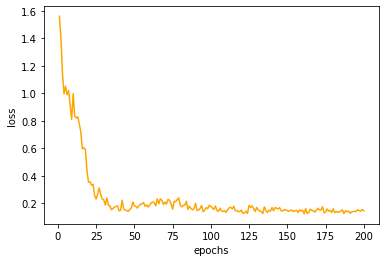

In [ ]:
_ = history_df['loss'].plot.line(xlabel='epochs', ylabel='loss', color='orange')

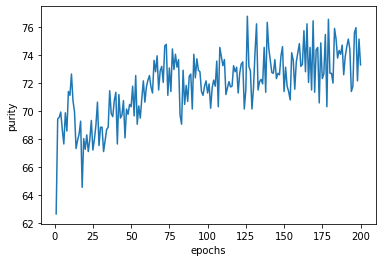

In [ ]:
_ = history_df['purity'].plot.line(xlabel='epochs', ylabel='purity')

# Linear Evaluation

Mostly modified from https://github.com/UMBCvision/CMSF/blob/main/self_supervised/eval_linear.py

Requires running the "Self-Supervised CMSF" section.

### Misc Setup

In [ ]:
def load_weights(model, wts_path, output_dim, arch):
    wts = torch.load(wts_path)
    # pdb.set_trace()
    if 'state_dict' in wts:
        ckpt = wts['state_dict']
    elif 'model' in wts:
        ckpt = wts['model']
    else:
        ckpt = wts

    ckpt = {k.replace('module.', ''): v for k, v in ckpt.items()}
    ckpt = {k: v for k, v in ckpt.items() if 'encoder_t' not in k}
    ckpt = {k.replace('encoder_q.', ''): v for k, v in ckpt.items()}
    state_dict = {}

    for m_key, m_val in model.state_dict().items():
        if m_key in ckpt:
            state_dict[m_key] = ckpt[m_key]
        else:
            state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    model.load_state_dict(state_dict)

    predict_q_ckpt = {k: v for k, v in ckpt.items() if 'predict_q' in k}
    predict_q_ckpt = {k.replace('predict_q.', ''): v for k, v in predict_q_ckpt.items()}
    predict_q_model = get_mlp(output_dim, output_dim * 2, output_dim)

    predict_q_state_dict = {}

    for m_key, m_val in predict_q_model.state_dict().items():
        if m_key in predict_q_ckpt:
            predict_q_state_dict[m_key] = predict_q_ckpt[m_key]
        else:
            predict_q_state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    predict_q_model.load_state_dict(predict_q_state_dict)

    if arch == 'healnet':
        model.fc_16 = nn.Sequential(model.fc_16, predict_q_model)
    else:
        model.fc = nn.Sequential(model.fc, predict_q_model)

In [ ]:
def get_model(arch, output_dim, wts_path):
    if arch == 'resnet_pretr':
        model, _ = initialize_encoder('resnet', output_dim)
        model.fc = nn.Sequential()
    elif arch == 'resnet_healnet_pretr':
        model, _ = initialize_encoder('resnet_healnet', output_dim)
    else:
        model, _ = initialize_encoder(arch, output_dim)
        load_weights(model, wts_path, output_dim, arch)

    # if arch == 'alexnet':
    #     model = AlexNet()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # elif arch == 'pt_alexnet':
    #     model = models.alexnet()
    #     classif = list(model.classifier.children())[:5]
    #     model.classifier = nn.Sequential(*classif)
    #     load_weights(model, wts_path)
    # elif arch == 'mobilenet':
    #     model = MobileNetV2()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # elif 'sup_resnet' in arch:
    #     model = models.__dict__[arch.replace('sup_', '')](pretrained=True)
    #     model.fc = nn.Sequential()
    # elif 'resnet' in arch:
    #     model = models.__dict__[arch]()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # else:
    #     raise ValueError('arch not found: ' + arch)

    for p in model.parameters():
        p.requires_grad = False

    return model

In [ ]:
class Normalize(nn.Module):
    def forward(self, x):
        return x / x.norm(2, dim=1, keepdim=True)


class FullBatchNorm(nn.Module):
    def __init__(self, var, mean):
        super(FullBatchNorm, self).__init__()
        self.register_buffer('inv_std', (1.0 / torch.sqrt(var + 1e-5)))
        self.register_buffer('mean', mean)

    def forward(self, x):
        return (x - self.mean) * self.inv_std

In [ ]:
def get_channels(arch):
    if arch == 'alexnet':
        c = 4096
    elif arch == 'pt_alexnet':
        c = 4096
    elif 'resnet50' in arch:
        c = 2048
    elif arch == 'resnet18':
        c = 512
    elif arch == 'mobilenet':
        c = 1280
    else:
        raise ValueError('arch not found: ' + arch)
    return c

In [ ]:
def normalize(x):
    return x / x.norm(2, dim=1, keepdim=True)

In [ ]:
def get_feats(loader, model, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, ptr = None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (indices, images, target) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = normalize(model(images)).cpu()
            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets.argmax(axis=1))
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels

### Training Functions

In [ ]:
def train(train_loader, backbone, linear, optimizer, epoch, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top2 = AverageMeter('Acc@2', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top2],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    backbone.eval()
    linear.train()

    end = time.time()
    for i, (indices, images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        with torch.no_grad():
            output = backbone(images)
        output = linear(output)
        loss = F.cross_entropy(output, target)

        # measure accuracy and record loss
        #true_labels = target.argmax(axis=1)
        true_labels = torch.tensor(labels_map[[train_loader.dataset.samples[x].split('/')[-1] for x in indices]]).cuda()
        acc1, acc2 = accuracy(output, true_labels, topk=(1, 2))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top2.update(acc2[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print(progress.display(i))

    return losses.avg, top1.avg.item(), top2.avg.item()

In [ ]:
def validate(val_loader, backbone, linear, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top2 = AverageMeter('Acc@2', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top2],
        prefix='Test: ')

    backbone.eval()
    linear.eval()

    with torch.no_grad():
        end = time.time()
        for i, (indices, images, target) in enumerate(val_loader):
            images = images.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = backbone(images)
            output = linear(output)
            loss = F.cross_entropy(output, target)

            # measure accuracy and record loss
            #true_labels = target.argmax(axis=1)
            true_labels = torch.tensor(labels_map[[val_loader.dataset.samples[x].split('/')[-1] for x in indices]]).cuda()
            acc1, acc2 = accuracy(output, true_labels, topk=(1, 2))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top2.update(acc2[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@2 {top2.avg:.3f}'
              .format(top1=top1, top2=top2))

    return losses.avg, top1.avg.item(), top2.avg.item()

In [ ]:
def main_worker(data, label_fn, weights, save, logger, batch_size=16, workers=2, 
                epochs=40, arch='resnet50', print_freq=10, mlp=True, lr=0.01, 
                momentum=0.9, weight_decay=1e-4, lr_schedule='15,30,40', 
                resume=None, evaluate=False, n_classes=4, output_dim=16):
    best_acc1 = 0
    best_loss = np.inf

    # Data loading code
    traindir = os.path.join(data, 'train')
    valdir = os.path.join(data, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.RandomRotation((0, 360)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = Image_Dataset(traindir, label_fn, train_transform)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True,
    )

    val_loader = torch.utils.data.DataLoader(
        Image_Dataset(valdir, label_fn, val_transform),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True,
    )

    train_val_loader = torch.utils.data.DataLoader(
        Image_Dataset(traindir, label_fn, val_transform),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True,
    )

    backbone = get_model(arch, output_dim, weights)
    backbone = nn.DataParallel(backbone).cuda()
    backbone.eval()


    cached_feats = '%s/var_mean.pth.tar' % save
    if not os.path.exists(cached_feats):
        train_feats, _ = get_feats(train_val_loader, backbone, print_freq, logger)
        train_var, train_mean = torch.var_mean(train_feats, dim=0)
        torch.save((train_var, train_mean), cached_feats)
    else:
        train_var, train_mean = torch.load(cached_feats)
    if arch == 'resnet_pretr':
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(512, n_classes)
        )
    elif mlp:
        c = output_dim
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(output_dim, c),
            nn.BatchNorm1d(c),
            nn.ReLU(inplace=True),
            nn.Linear(c, c),
            nn.BatchNorm1d(c),
            nn.ReLU(inplace=True),
            nn.Linear(c, n_classes),
        )
    else:
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(output_dim, n_classes)
        )

    print(backbone)
    print(linear)

    linear = linear.cuda()

    optimizer = torch.optim.SGD(linear.parameters(),
                                lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

    sched = [int(x) for x in lr_schedule.split(',')]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=sched
    )

    start_epoch = 0
    history_df = pd.DataFrame(index=range(start_epoch + 1, epochs + 1))

    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            linear.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            history_df = checkpoint['history_df']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    cudnn.benchmark = True

    if evaluate:
        validate(val_loader, backbone, linear, print_freq, logger)
        return

    for epoch in range(start_epoch, epochs):
        # train for one epoch
        loss, acc1, acc2 = train(
            train_loader, backbone, linear, optimizer, epoch, print_freq, logger)

        # evaluate on validation set
        val_loss, val_acc1, val_acc2 = validate(
            val_loader, backbone, linear, print_freq, logger)
        
        history_df.loc[epoch + 1, 'train_loss'] = loss
        history_df.loc[epoch + 1, 'train_acc1'] = acc1
        history_df.loc[epoch + 1, 'train_acc2'] = acc2
        history_df.loc[epoch + 1, 'val_loss'] = val_loss
        history_df.loc[epoch + 1, 'val_acc1'] = val_acc1
        history_df.loc[epoch + 1, 'val_acc2'] = val_acc2

        # modify lr
        lr_scheduler.step()
        # logger.info('LR: {:f}'.format(lr_scheduler.get_last_lr()[-1]))

        # remember best acc@1 and save checkpoint
        is_best = val_acc1 >= best_acc1
        #is_best = val_loss < best_loss
        if is_best:
            best_loss = val_loss
            best_acc1 = val_acc1


        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': linear.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'backbone': backbone,
            'linear': linear,
            'history_df': history_df
        }, is_best, save)

    return backbone, linear

In [ ]:
!touch logger_init
def main_linear_eval(data, label_fn, weights, save, batch_size=16, workers=2, 
                     epochs=40, arch='resnet50', print_freq=10, mlp=True, lr=0.01, 
                     momentum=0.9, weight_decay=1e-4, lr_schedule='15,30,40', 
                     resume=None, evaluate=False, seed=None, n_classes=4, output_dim=16):
    args = locals()
    del args['label_fn']

    if not resume:
        os.makedirs(save)
    logger = get_logger(logpath=os.path.join(save, 'logs'), filepath='logger_init')
    print(args)

    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    return main_worker(data=data, label_fn=label_fn, weights=weights, save=save, 
                       logger=logger, batch_size=batch_size, workers=workers, 
                       epochs=epochs, arch=arch, print_freq=print_freq, mlp=mlp, 
                       lr=lr, momentum=momentum, weight_decay=weight_decay, 
                       lr_schedule=lr_schedule, resume=resume, evaluate=evaluate, 
                       n_classes=n_classes, output_dim=output_dim)

### Getting Labels

In [ ]:
labels_df = pd.read_csv(root_path + 'Updated_Cropped_Images_Wound_Stage_Probabilities.csv', index_col='Image')
labels_df.head()

hemostasis  inflammatory  proliferative  maturation
Image                                                                 
Day 8_A8-4-L.png     0.181818      0.090909       0.545455    0.181818
Day 4_A8-3-R.png     0.090909      0.909091       0.000000    0.000000
Day 14_Y8-4-L.png    0.000000      0.000000       0.090909    0.909091
Day 7_Y8-4-L.png     0.000000      0.000000       0.454545    0.545455
Day 2_A8-1-L.png     0.181818      0.727273       0.090909    0.000000

In [ ]:
labels_df.loc['Day 8_A8-4-L.png'].to_numpy()

array([0.18181818, 0.09090909, 0.54545455, 0.18181818])

### Output Folder

In [ ]:
eval_suffix = '_2_lin_'

# Linear Evaluation Training

Edit the last cell in the section above to control the output folder. Evaluates Every 10th epoch up to epoch 200 of a CMSF model.

### Training

In [ ]:
for eval_epoch in range(10, 201, 10):
    print("\n\n\n\nEVALUATING EPOCH", eval_epoch, "\n\n")
    _, _ = main_linear_eval(
        data=root_path + 'Split_images', 
        label_fn=lambda x: labels_df.loc[x].to_numpy(), 
        weights=root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + str(eval_epoch) + '.pth',
        save=root_path + 'outputs/' + train_folder_name + 'eval' + eval_suffix + str(eval_epoch) + '/', 
        batch_size=8, 
        lr=0.01,
        epochs=40, 
        mlp=False,
        workers=2, 
        arch='resnet_healnet', 
        print_freq=10,  
        output_dim=16)

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init













EVALUATING EPOCH 10 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_10.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_10/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.293 ( 0.293)
Test: [10/24]	Time  0.039 ( 0.054)
Test: [20/24]	Time  0.059 ( 0.044)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init














EVALUATING EPOCH 20 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_20.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_20/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.179 ( 0.179)
Test: [10/24]	Time  0.056 ( 0.046)
Test: [20/24]	Time  0.054 ( 0.041)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init















EVALUATING EPOCH 30 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_30.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_30/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.317 ( 0.317)
Test: [10/24]	Time  0.019 ( 0.058)
Test: [20/24]	Time  0.040 ( 0.046)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
















EVALUATING EPOCH 40 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_40.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_40/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.207 ( 0.207)
Test: [10/24]	Time  0.030 ( 0.045)
Test: [20/24]	Time  0.046 ( 0.039)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init

















EVALUATING EPOCH 50 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_50.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_50/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.281 ( 0.281)
Test: [10/24]	Time  0.042 ( 0.053)
Test: [20/24]	Time  0.054 ( 0.043)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init


















EVALUATING EPOCH 60 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_60.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_60/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.226 ( 0.226)
Test: [10/24]	Time  0.022 ( 0.049)
Test: [20/24]	Time  0.045 ( 0.042)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init



















EVALUATING EPOCH 70 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_70.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_70/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.264 ( 0.264)
Test: [10/24]	Time  0.014 ( 0.051)
Test: [20/24]	Time  0.048 ( 0.043)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init




















EVALUATING EPOCH 80 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_80.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_80/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.254 ( 0.254)
Test: [10/24]	Time  0.015 ( 0.049)
Test: [20/24]	Time  0.013 ( 0.041)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init





















EVALUATING EPOCH 90 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_90.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_90/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.301 ( 0.301)
Test: [10/24]	Time  0.024 ( 0.054)
Test: [20/24]	Time  0.028 ( 0.045)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init






















EVALUATING EPOCH 100 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_100.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_100/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.202 ( 0.202)
Test: [10/24]	Time  0.049 ( 0.047)
Test: [20/24]	Time  0.052 ( 0.041)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init























EVALUATING EPOCH 110 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_110.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_110/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.313 ( 0.313)
Test: [10/24]	Time  0.045 ( 0.060)
Test: [20/24]	Time  0.049 ( 0.047)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
























EVALUATING EPOCH 120 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_120.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_120/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.200 ( 0.200)
Test: [10/24]	Time  0.019 ( 0.051)
Test: [20/24]	Time  0.017 ( 0.043)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init

























EVALUATING EPOCH 130 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_130.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_130/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.321 ( 0.321)
Test: [10/24]	Time  0.025 ( 0.058)
Test: [20/24]	Time  0.019 ( 0.047)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init


























EVALUATING EPOCH 140 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_140.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_140/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.189 ( 0.189)
Test: [10/24]	Time  0.014 ( 0.047)
Test: [20/24]	Time  0.013 ( 0.042)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init



























EVALUATING EPOCH 150 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_150.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_150/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.308 ( 0.308)
Test: [10/24]	Time  0.050 ( 0.056)
Test: [20/24]	Time  0.034 ( 0.045)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init




























EVALUATING EPOCH 160 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_160.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_160/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.195 ( 0.195)
Test: [10/24]	Time  0.046 ( 0.049)
Test: [20/24]	Time  0.029 ( 0.040)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init





























EVALUATING EPOCH 170 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_170.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_170/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.324 ( 0.324)
Test: [10/24]	Time  0.015 ( 0.056)
Test: [20/24]	Time  0.017 ( 0.046)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init






























EVALUATING EPOCH 180 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_180.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_180/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.266 ( 0.266)
Test: [10/24]	Time  0.013 ( 0.052)
Test: [20/24]	Time  0.052 ( 0.043)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init































EVALUATING EPOCH 190 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_190.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_190/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.338 ( 0.338)
Test: [10/24]	Time  0.041 ( 0.057)
Test: [20/24]	Time  0.053 ( 0.045)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
logger_init
































EVALUATING EPOCH 200 


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/ckpt_epoch_200.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised_finals/1_ww/eval_2_lin_200/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.311 ( 0.311)
Test: [10/24]	Time  0.053 ( 0.062)
Test: [20/24]	Time  0.049 ( 0.048)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

### Graphs

In [ ]:
epoch = '10'

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/checkpoint.pth.tar')
history_df = cpkt['history_df']
cpkt['epoch']

40

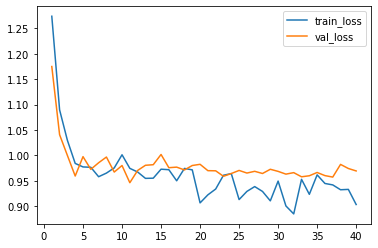

In [ ]:
_ = history_df[['train_loss', 'val_loss']].plot.line()

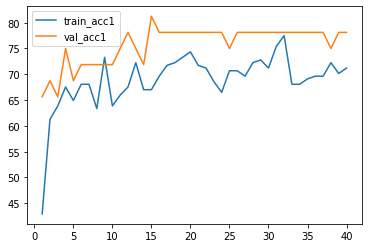

In [ ]:
_ = history_df[['train_acc1', 'val_acc1']].plot.line()

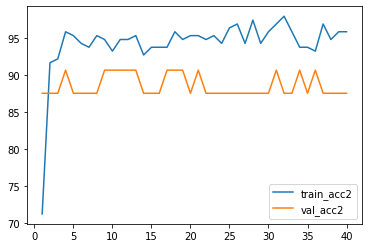

In [ ]:
_ = history_df[['train_acc2', 'val_acc2']].plot.line()

# Test Set

Evaluations on the test dataset. Requires running the "Linear Evaluation" section.

In [ ]:
train_folder_name

'unsupervised_finals/1_ww/'

In [ ]:
test_loader, samples = get_val_loader(
    root_path + 'Split_images',
    lambda x: labels_df.loc[x].to_numpy(),
    2,
    test=True)

In [ ]:
best_val_acc = 0
val_accs = []
best_eval_epoch, best_ckpt = None, None
for eval_epoch in range(10, 201, 10):
    ckpt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + str(eval_epoch) + '/model_best.pth.tar')
    best_epoch = ckpt['epoch']
    val_acc = ckpt['history_df']['val_acc1'][best_epoch]
    val_accs.append(val_acc)

    if val_acc >= best_val_acc:
        best_eval_epoch = eval_epoch
        best_val_acc = val_acc
        best_ckpt = ckpt
  
ckpt = best_ckpt 

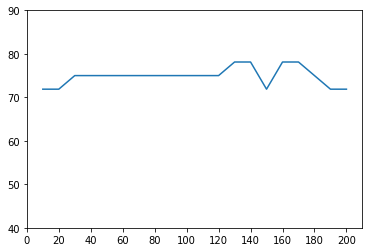

In [ ]:
plt.plot(np.arange(10, 201, 10), val_accs)
plt.xticks(np.arange(0, 201, 20))
plt.ylim(bottom=40, top=90)
plt.show()

In [ ]:
backbone = ckpt['backbone']
linear = ckpt['linear']

backbone.eval()
linear.eval()

preds, names, labels = None, None, None

with torch.no_grad():
    for indices, images, labels in test_loader:
        preds = linear(backbone(images)).softmax(dim=1).cpu().numpy()
        names = np.array([x.split('/')[-1] for x in samples])
        labels = labels.numpy()


df = pd.DataFrame(index=names)
preds = [list(x) for x in preds]
labels = [list(x) for x in labels]
df['target'] = labels
df['pred'] = preds
df['True'] = (df.index.map(lambda x: labels_map[x]))
df['Pred'] = (df.index.map(lambda x: np.argmax(df.loc[x]['pred'])))
test_acc = (df['True'] == df['Pred']).mean() * 100

print("Best CMSF Epoch:", best_eval_epoch)
print(f"Best Lin Epoch: {ckpt['epoch']}, Val_acc: {best_val_acc}, Test_acc: {test_acc}")

Best CMSF Epoch: 170
Best Lin Epoch: 3, Val_acc: 78.125, Test_acc: 81.25


In [ ]:
props = df.index.map(lambda x: re.match('^Day (\d+)_(Y|A)8-(\d)-(L|R)', x).groups())
df['Day'] = props.map(lambda x: int(x[0]))
df['Age'] = props.map(lambda x: x[1])
df['Mouse'] = props.map(lambda x: int(x[2]))
df['Side'] = props.map(lambda x: x[3])
df.head()

target  \
Day 14_Y8-4-L.png  [0.0, 0.0, 0.0909090909090909, 0.909090909090909]   
Day 7_Y8-4-L.png    [0.0, 0.0, 0.454545454545455, 0.545454545454545]   
Day 9_A8-1-R.png   [0.0909090909090909, 0.454545454545455, 0.4545...   
Day 4_A8-1-R.png    [0.363636363636364, 0.636363636363636, 0.0, 0.0]   
Day 12_A8-1-R.png                               [0.0, 0.2, 0.5, 0.3]   

                                                                pred  True  \
Day 14_Y8-4-L.png  [0.040679686, 0.040569365, 0.12431813, 0.79443...     3   
Day 7_Y8-4-L.png      [0.05373401, 0.17272504, 0.5324961, 0.2410448]     2   
Day 9_A8-1-R.png    [0.2571589, 0.46965304, 0.24868631, 0.024501696]     1   
Day 4_A8-1-R.png   [0.54901344, 0.39887518, 0.039518196, 0.012593...     1   
Day 12_A8-1-R.png  [0.024115818, 0.12034136, 0.51466215, 0.34088066]     2   

                   Pred  Day Age  Mouse Side  
Day 14_Y8-4-L.png     3   14   Y      4    L  
Day 7_Y8-4-L.png      2    7   Y      4    L  
Day 9_A8-1-R.png      1    9   A      1    R  
Day 4_A8-1-R.png      0    4   A      1    R  
Day 12_A8-1-R.png     2   12   A      1    R

In [ ]:
young_df = df[df.Age == 'Y'].sort_values('Day')
young_df[['target', 'pred', 'True', 'Pred']]

target  \
Day 0_Y8-4-L.png                                [1.0, 0.0, 0.0, 0.0]   
Day 1_Y8-4-L.png                              [0.57, 0.43, 0.0, 0.0]   
Day 2_Y8-4-L.png                                [0.8, 0.2, 0.0, 0.0]   
Day 3_Y8-4-L.png                                [0.2, 0.8, 0.0, 0.0]   
Day 4_Y8-4-L.png                                [0.4, 0.5, 0.1, 0.0]   
Day 5_Y8-4-L.png                                [0.3, 0.5, 0.2, 0.0]   
Day 6_Y8-4-L.png                                [0.1, 0.3, 0.6, 0.0]   
Day 7_Y8-4-L.png    [0.0, 0.0, 0.454545454545455, 0.545454545454545]   
Day 8_Y8-4-L.png                                [0.0, 0.0, 0.6, 0.4]   
Day 9_Y8-4-L.png                                [0.0, 0.0, 0.6, 0.4]   
Day 10_Y8-4-L.png                               [0.0, 0.0, 0.1, 0.9]   
Day 11_Y8-4-L.png                               [0.0, 0.0, 0.0, 1.0]   
Day 12_Y8-4-L.png                               [0.0, 0.0, 0.1, 0.9]   
Day 13_Y8-4-L.png                               [0.0, 0.0, 0.0, 1.0]   
Day 14_Y8-4-L.png  [0.0, 0.0, 0.0909090909090909, 0.909090909090909]   
Day 15_Y8-4-L.png                               [0.0, 0.0, 0.0, 1.0]   

                                                                pred  True  \
Day 0_Y8-4-L.png   [0.7454775, 0.23618263, 0.012519295, 0.0058206...     0   
Day 1_Y8-4-L.png     [0.042821553, 0.2827062, 0.5922565, 0.08221578]     0   
Day 2_Y8-4-L.png   [0.5828555, 0.37736687, 0.028737599, 0.011040037]     0   
Day 3_Y8-4-L.png    [0.11037558, 0.48725423, 0.35951787, 0.04285225]     1   
Day 4_Y8-4-L.png   [0.73952526, 0.24293423, 0.009981378, 0.007559...     1   
Day 5_Y8-4-L.png     [0.26703018, 0.5059373, 0.19451477, 0.03251774]     1   
Day 6_Y8-4-L.png    [0.056312002, 0.31703916, 0.5089537, 0.11769514]     2   
Day 7_Y8-4-L.png      [0.05373401, 0.17272504, 0.5324961, 0.2410448]     2   
Day 8_Y8-4-L.png     [0.03176965, 0.18188883, 0.6253494, 0.16099204]     2   
Day 9_Y8-4-L.png     [0.033091728, 0.15396658, 0.51537865, 0.297563]     2   
Day 10_Y8-4-L.png  [0.027432373, 0.054119162, 0.19728784, 0.7211606]     3   
Day 11_Y8-4-L.png    [0.052102827, 0.06524495, 0.18839526, 0.694257]     3   
Day 12_Y8-4-L.png  [0.040094633, 0.03348268, 0.09573354, 0.83068913]     3   
Day 13_Y8-4-L.png  [0.031633154, 0.03588859, 0.11631291, 0.81616527]     3   
Day 14_Y8-4-L.png  [0.040679686, 0.040569365, 0.12431813, 0.79443...     3   
Day 15_Y8-4-L.png    [0.02732598, 0.04025213, 0.14111301, 0.7913088]     3   

                   Pred  
Day 0_Y8-4-L.png      0  
Day 1_Y8-4-L.png      2  
Day 2_Y8-4-L.png      0  
Day 3_Y8-4-L.png      1  
Day 4_Y8-4-L.png      0  
Day 5_Y8-4-L.png      1  
Day 6_Y8-4-L.png      2  
Day 7_Y8-4-L.png      2  
Day 8_Y8-4-L.png      2  
Day 9_Y8-4-L.png      2  
Day 10_Y8-4-L.png     3  
Day 11_Y8-4-L.png     3  
Day 12_Y8-4-L.png     3  
Day 13_Y8-4-L.png     3  
Day 14_Y8-4-L.png     3  
Day 15_Y8-4-L.png     3

In [ ]:
aged_df = df[df.Age == 'A'].sort_values('Day')
aged_df[['target', 'pred', 'True', 'Pred']]

target  \
Day 0_A8-1-R.png                                [0.9, 0.1, 0.0, 0.0]   
Day 1_A8-1-R.png                                [0.1, 0.8, 0.1, 0.0]   
Day 2_A8-1-R.png                                [0.4, 0.5, 0.1, 0.0]   
Day 3_A8-1-R.png                                [0.4, 0.5, 0.1, 0.0]   
Day 4_A8-1-R.png    [0.363636363636364, 0.636363636363636, 0.0, 0.0]   
Day 5_A8-1-R.png                                [0.2, 0.5, 0.3, 0.0]   
Day 6_A8-1-R.png                                [0.2, 0.7, 0.1, 0.0]   
Day 7_A8-1-R.png                                [0.1, 0.7, 0.1, 0.1]   
Day 8_A8-1-R.png                                [0.2, 0.6, 0.2, 0.0]   
Day 9_A8-1-R.png   [0.0909090909090909, 0.454545454545455, 0.4545...   
Day 10_A8-1-R.png                               [0.1, 0.4, 0.5, 0.0]   
Day 11_A8-1-R.png                               [0.0, 0.1, 0.8, 0.1]   
Day 12_A8-1-R.png                               [0.0, 0.2, 0.5, 0.3]   
Day 13_A8-1-R.png                               [0.0, 0.1, 0.5, 0.4]   
Day 14_A8-1-R.png                               [0.0, 0.1, 0.3, 0.6]   
Day 15_A8-1-R.png                               [0.0, 0.1, 0.6, 0.3]   

                                                                pred  True  \
Day 0_A8-1-R.png   [0.6579219, 0.31295335, 0.020357898, 0.008766835]     0   
Day 1_A8-1-R.png    [0.092844665, 0.30965897, 0.5100751, 0.08742124]     1   
Day 2_A8-1-R.png   [0.38054895, 0.5301475, 0.065614864, 0.023688646]     1   
Day 3_A8-1-R.png     [0.5915792, 0.3742784, 0.02429548, 0.009846934]     1   
Day 4_A8-1-R.png   [0.54901344, 0.39887518, 0.039518196, 0.012593...     1   
Day 5_A8-1-R.png   [0.24473034, 0.57690847, 0.14564377, 0.032717474]     1   
Day 6_A8-1-R.png   [0.27181304, 0.52546513, 0.17883073, 0.023891112]     1   
Day 7_A8-1-R.png    [0.22230862, 0.5109695, 0.23911896, 0.027602894]     1   
Day 8_A8-1-R.png    [0.2139942, 0.48525417, 0.27939293, 0.021358779]     1   
Day 9_A8-1-R.png    [0.2571589, 0.46965304, 0.24868631, 0.024501696]     1   
Day 10_A8-1-R.png     [0.08959956, 0.35658976, 0.5178889, 0.0359217]     2   
Day 11_A8-1-R.png     [0.05186892, 0.2674221, 0.623896, 0.056812957]     2   
Day 12_A8-1-R.png  [0.024115818, 0.12034136, 0.51466215, 0.34088066]     2   
Day 13_A8-1-R.png    [0.030427907, 0.20081934, 0.6412122, 0.1275405]     2   
Day 14_A8-1-R.png  [0.042570993, 0.15626965, 0.53243744, 0.26872197]     3   
Day 15_A8-1-R.png    [0.03378906, 0.06231018, 0.23177636, 0.6721244]     3   

                   Pred  
Day 0_A8-1-R.png      0  
Day 1_A8-1-R.png      2  
Day 2_A8-1-R.png      1  
Day 3_A8-1-R.png      0  
Day 4_A8-1-R.png      0  
Day 5_A8-1-R.png      1  
Day 6_A8-1-R.png      1  
Day 7_A8-1-R.png      1  
Day 8_A8-1-R.png      1  
Day 9_A8-1-R.png      1  
Day 10_A8-1-R.png     2  
Day 11_A8-1-R.png     2  
Day 12_A8-1-R.png     2  
Day 13_A8-1-R.png     2  
Day 14_A8-1-R.png     2  
Day 15_A8-1-R.png     3

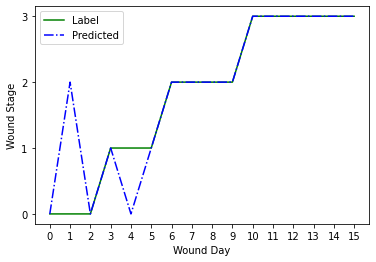

In [ ]:
plt.plot(young_df['Day'], young_df['True'], linestyle='-', color='g', label='Label')
plt.plot(young_df['Day'], young_df['Pred'], linestyle='-.', color='b', label='Predicted')
plt.xticks(range(16))
plt.yticks(range(4))
plt.xlabel('Wound Day')
plt.ylabel('Wound Stage')
plt.legend()
plt.show()

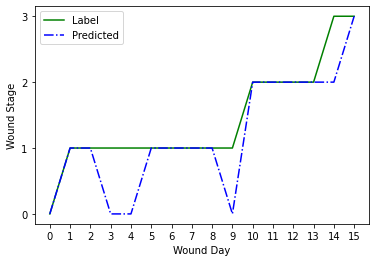

In [ ]:
plt.plot(aged_df['Day'], aged_df['True'], linestyle='-', color='g', label='Label')
plt.plot(aged_df['Day'], aged_df['Pred'], linestyle='-.', color='b', label='Predicted')
plt.xticks(range(16))
plt.yticks(range(4))
plt.xlabel('Wound Day')
plt.ylabel('Wound Stage')
plt.legend()
plt.show()

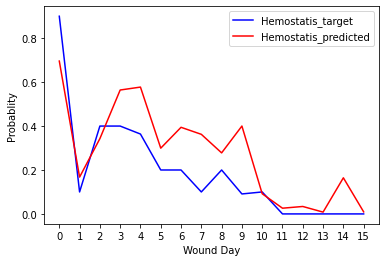

In [ ]:
plt.plot(aged_df['Day'], aged_df['target'].map(lambda x: x[0]), linestyle='-', color='b', label='Hemostatis_target')
plt.plot(aged_df['Day'], aged_df['pred'].map(lambda x: x[0]), linestyle='-', color='r', label='Hemostatis_predicted')
plt.xticks(range(16))
plt.xlabel('Wound Day')
plt.ylabel('Probablity')
plt.legend()

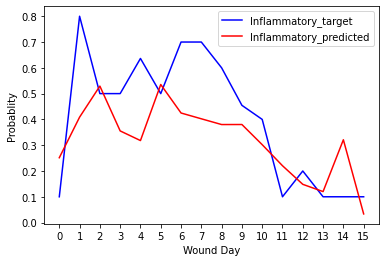

In [ ]:
plt.plot(aged_df['Day'], aged_df['target'].map(lambda x: x[1]), linestyle='-', color='b', label='Inflammatory_target')
plt.plot(aged_df['Day'], aged_df['pred'].map(lambda x: x[1]), linestyle='-', color='r', label='Inflammatory_predicted')
plt.xticks(range(16))
plt.xlabel('Wound Day')
plt.ylabel('Probablity')
plt.legend()


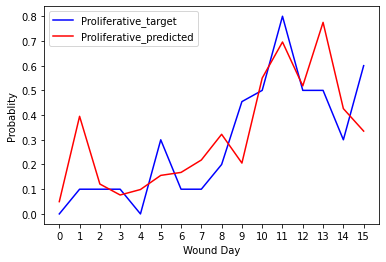

In [ ]:
plt.plot(aged_df['Day'], aged_df['target'].map(lambda x: x[2]), linestyle='-', color='b', label='Proliferative_target')
plt.plot(aged_df['Day'], aged_df['pred'].map(lambda x: x[2]), linestyle='-', color='r', label='Proliferative_predicted')
plt.xticks(range(16))
plt.xlabel('Wound Day')
plt.ylabel('Probablity')
plt.legend()

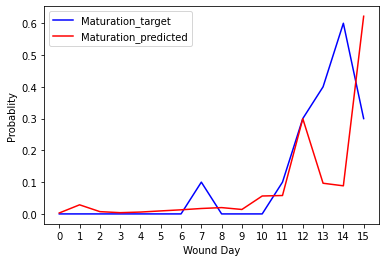

In [ ]:
plt.plot(aged_df['Day'], aged_df['target'].map(lambda x: x[3]), linestyle='-', color='b', label='Maturation_target')
plt.plot(aged_df['Day'], aged_df['pred'].map(lambda x: x[3]), linestyle='-', color='r', label='Maturation_predicted')
plt.xticks(range(16))
plt.xlabel('Wound Day')
plt.ylabel('Probablity')
plt.legend()

# KNN Evaluation

KNN evaluation of a CMSF model. Requires running the "Self-Supervised CMSF" section.

First two sections modified from https://github.com/UMBCvision/CMSF/blob/main/self_supervised/eval_knn.py

### Misc Functions

In [ ]:
def l2_normalize(x):
    return x / x.norm(2, dim=1, keepdim=True)

In [ ]:
def log(string, file):
    print(string)
    file.write(string + '\n')

In [ ]:
def faiss_knn(feats_train, targets_train, feats_val, targets_val, k):
    feats_train = feats_train.numpy()
    targets_train = targets_train.numpy()
    feats_val = feats_val.numpy()
    targets_val = targets_val.numpy()

    d = feats_train.shape[-1]

    index = faiss.IndexFlatL2(d)  # build the index
    co = faiss.GpuMultipleClonerOptions()
    co.useFloat16 = True
    co.shard = True
    gpu_index = faiss.index_cpu_to_all_gpus(index, co)
    gpu_index.add(feats_train)

    D, I = gpu_index.search(feats_val, k)

    pred = np.zeros(I.shape[0], dtype=int)
    conf_mat = np.zeros((1000, 1000), dtype=int)
    for i in range(I.shape[0]):
        votes = list(Counter(targets_train[I[i]]).items())
        shuffle(votes)
        pred[i] = max(votes, key=lambda x: x[1])[0]
        conf_mat[targets_val[i], pred[i]] += 1

    acc = 100.0 * (pred == targets_val).mean()
    assert acc == (100.0 * (np.trace(conf_mat) / np.sum(conf_mat)))

    # per_cat_acc = 100.0 * (np.diag(conf_mat) / np.sum(conf_mat, axis=1))
    # sparse_cats = [58, 155, 356, 747, 865, 234, 268, 384, 385, 491, 498, 538, 646, 650, 726, 860, 887, 15, 170, 231]
    # s = ' '.join('{}'.format(c) for c in sparse_cats)
    # print('==> cats: {}'.format(s))
    # s = ' '.join('{:.1f}'.format(a) for a in per_cat_acc[sparse_cats])
    # print('==> acc/cat: {}'.format(s))
    # print('==> mean acc: {}'.format(per_cat_acc[sparse_cats].mean()))

    return acc, pred

In [ ]:
def get_feats(loader, model, print_freq):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, indices, ptr = None, None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (index, images, target) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = model(images).cpu()
            cur_indices = index.cpu()

            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()
                indices = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets)
            indices.index_copy_(0, inds, cur_indices)
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels, indices

In [ ]:
def subset_classes(dataset, num_classes=10):
    np.random.seed(1234)
    all_classes = sorted(dataset.class_to_idx.items(), key=lambda x: x[1])
    subset_classes = [all_classes[i] for i in np.random.permutation(len(all_classes))[:num_classes]]
    subset_classes = sorted(subset_classes, key=lambda x: x[1])
    dataset.classes_to_idx = {c: i for i, (c, _) in enumerate(subset_classes)}
    dataset.classes = [c for c, _ in subset_classes]
    orig_to_new_inds = {orig_ind: new_ind for new_ind, (_, orig_ind) in enumerate(subset_classes)}
    dataset.samples = [(p, orig_to_new_inds[i]) for p, i in dataset.samples if i in orig_to_new_inds]

### Main Function

In [ ]:
def main_worker(arch, output_dim, data_path, wts_path, output_path, 
                label_fn, num_workers=2, print_freq=10, ks=range(1,21)):

    start = time.time()
    # Get train/val loader 
    # ---------------------------------------------------------------
    train_loader, _ = get_val_loader(data_path, label_fn, num_workers, train=True)
    val_loader, val_samples   = get_val_loader(data_path, label_fn, num_workers)
    test_loader, test_samples  = get_val_loader(data_path, label_fn, num_workers, test=True)

    val_names = np.array([x.split('/')[-1] for x in val_samples])
    test_names = names = np.array([x.split('/')[-1] for x in test_samples])

    # Create and load the model
    # If you want to evaluate your model, modify this part and load your model
    # ------------------------------------------------------------------------
    # MODIFY 'get_model' TO EVALUATE YOUR MODEL
    model = get_model(arch, output_dim, wts_path).cuda()

    # ------------------------------------------------------------------------
    # Forward training samples throw the model and cache feats
    # ------------------------------------------------------------------------
    cudnn.benchmark = True

    train_feats, train_labels, train_inds = get_feats(train_loader, model, print_freq)

    val_feats, val_labels, val_inds = get_feats(val_loader, model, print_freq)

    test_feats, test_labels, test_inds = get_feats(test_loader, model, print_freq)

    # ------------------------------------------------------------------------
    # Calculate NN accuracy on validation set
    # ------------------------------------------------------------------------

    # train_feats = l2_normalize(train_feats)
    # val_feats = l2_normalize(val_feats)

    # mean = torch.mean(train_feats, dim=0)
    # std = torch.std(train_feats, dim=0)

    # stdmean = std.mean()
    # train_feats = train_feats / stdmean
    # val_feats = val_feats / stdmean

    # train_feats = train_feats / std
    # val_feats = val_feats / std

    # train_feats = (train_feats - mean) / std
    # val_feats = (val_feats - mean) / std

    # train_feats = train_feats - mean
    # val_feats = val_feats - mean

    # train_feats = train_feats / TEMP
    # val_feats = val_feats / TEMP

    train_feats = l2_normalize(train_feats)
    val_feats = l2_normalize(val_feats)
    test_feats = l2_normalize(test_feats)

    output = open(output_path, 'w')

    eval_dict = {}

    for k in ks:
        log(f'k: {k}', output)
        val_acc, val_pred  = faiss_knn(train_feats, train_labels, val_feats, val_labels, k)
        test_acc, test_pred = faiss_knn(train_feats, train_labels, test_feats, test_labels, k)
        nn_time = time.time() - start
        #log('=> time : {:.2f}s'.format(nn_time), output)
        log(' * Val_Acc {:.2f}'.format(val_acc), output)
        log(' * Test_Acc {:.2f}'.format(test_acc), output)

        eval_dict[k] = {'Val_acc': val_acc, 'Test_acc': test_acc, 'Val_pred': val_pred, 'Test_pred': test_pred}
    
    output.close()
    return eval_dict, val_names, test_names

### Evaluation

In [ ]:
eval_suf = '_1_'
out_fldr = root_path + 'outputs/' + train_folder_name + 'eval' + eval_suf + 'knn/'

In [ ]:
eval_dict = {}
os.makedirs(out_fldr)

for eval_epoch in range(10, 201, 10):
    print('\nEVAL EPOCH', eval_epoch)
    out, val_names, test_names = main_worker(
        arch='resnet_healnet', 
        output_dim=16, 
        data_path=root_path + 'Split_images', 
        wts_path=root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + str(eval_epoch) + '.pth', 
        output_path=out_fldr + str(eval_epoch), 
        label_fn=lambda x: labels_map[x], 
        num_workers=2, 
        print_freq=10,
        ks=range[1,5,10])
    eval_dict[eval_epoch] = {'out': out, 'val_names': val_names, 'test_names': test_names}

torch.save(eval_dict, out_fldr + 'eval_dict.pth')

FileExistsError: ignored

### Analysis

In [ ]:
eval_dict = torch.load(out_fldr + 'eval_dict.pth')

In [ ]:
best_epoch = None
for k in [1, 5, 10]:
    print('k:', k)
    best_val_acc = 0
    for epoch in eval_dict:
        out = eval_dict[epoch]['out']
        accs = out[k]
        val_acc = accs['Val_acc']
        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            best_epoch, best_k = epoch, k
    print("Best CMSF Epoch:", best_epoch)
    print(eval_dict[best_epoch]['out'][k]['Val_acc'], eval_dict[best_epoch]['out'][k]['Test_acc'])

k: 1
Best CMSF Epoch: 170
75.0 62.5
k: 5
Best CMSF Epoch: 160
75.0 78.125
k: 10
Best CMSF Epoch: 180
75.0 78.125


In [ ]:
best_k = 10

In [ ]:
val_df = pd.DataFrame(index=eval_dict[best_epoch]['val_names'])
val_df['Pred'] = eval_dict[best_epoch]['out'][best_k]['Val_pred']
val_df['True'] = (val_df.index.map(lambda x: labels_map[x]))

props = val_df.index.map(lambda x: re.match('^Day (\d+)_(Y|A)8-(\d)-(L|R)', x).groups())
val_df['Day'] = props.map(lambda x: int(x[0]))
val_df['Age'] = props.map(lambda x: x[1])

test_df = pd.DataFrame(index=eval_dict[best_epoch]['test_names'])
test_df['Pred'] = eval_dict[best_epoch]['out'][best_k]['Test_pred']
test_df['True'] = (test_df.index.map(lambda x: labels_map[x]))

props = test_df.index.map(lambda x: re.match('^Day (\d+)_(Y|A)8-(\d)-(L|R)', x).groups())
test_df['Day'] = props.map(lambda x: int(x[0]))
test_df['Age'] = props.map(lambda x: x[1])

In [ ]:
val_young_df = val_df[val_df.Age == 'Y'].sort_values('Day')
val_aged_df = val_df[val_df.Age == 'A'].sort_values('Day')
test_young_df = test_df[test_df.Age == 'Y'].sort_values('Day')
test_aged_df = test_df[test_df.Age == 'A'].sort_values('Day')

In [ ]:
def get_plot(title, df):
    plt.plot(df['Day'], df['True'], linestyle='-', color='g', label='Label')
    plt.plot(df['Day'], df['Pred'], linestyle='-.', color='b', label='Predicted')
    plt.xticks(range(16))
    plt.yticks(range(4))
    plt.xlabel('Wound Day')
    plt.ylabel('Wound Stage')
    plt.title(title)
    plt.legend()
    plt.show()

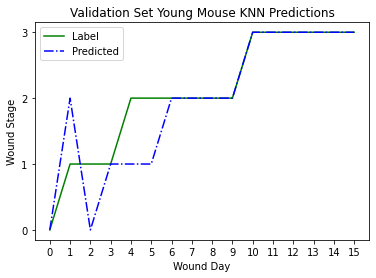

In [ ]:
get_plot('Validation Set Young Mouse KNN Predictions', val_young_df)

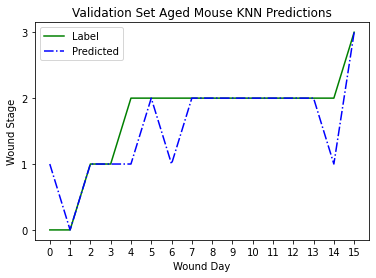

In [ ]:
get_plot('Validation Set Aged Mouse KNN Predictions', val_aged_df)

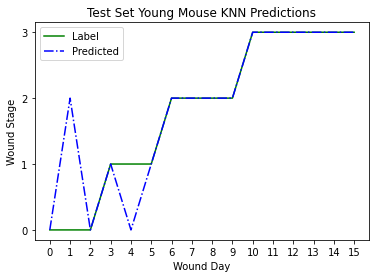

In [ ]:
get_plot('Test Set Young Mouse KNN Predictions', test_young_df)

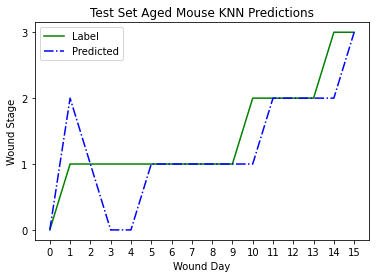

In [ ]:
get_plot('Test Set Aged Mouse KNN Predictions', test_aged_df)

# RISE

Generate saliency maps with RISE as in https://github.com/eclique/RISE/blob/master/Saliency.ipynb

Requires running a CMSF section and the "Linear Evaluation" section

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/model_best.pth.tar')
backbone = cpkt['backbone']
linear = cpkt['linear']

for p in backbone.parameters():
    p.requires_grad = False
for p in linear.parameters():
    p.requires_grad = False

model = lambda x: linear(backbone(x)).softmax(dim=1)

In [ ]:
explainer = RISE(model, (224, 224), 250)

In [ ]:
# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Generating filters: 100%|██████████| 6000/6000 [00:28<00:00, 206.98it/s]


In [ ]:
class_name = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

In [ ]:
def example(img, top_k, image_name):
    saliency = explainer(img.cuda()).cpu().numpy()
    p, c = torch.topk(model(img.cuda()), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], class_name[c[k]]))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(class_name[c[k]])
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    true_dist  = labels_df.loc[image_name].to_numpy()
    true_label = class_name[true_dist.argmax()]
    pred_dist  = model(img).squeeze().detach().cpu().numpy()
    pred_label = class_name[pred_dist.argmax()]

    plt.suptitle('%s\nTrue: %s (%s)\nPred: %s (%s)' % (
        image_name, 
        np.array2string(true_dist, precision=3, floatmode='fixed'), 
        true_label, 
        np.array2string(pred_dist, precision=3, floatmode='fixed'), 
        pred_label))
    plt.show()

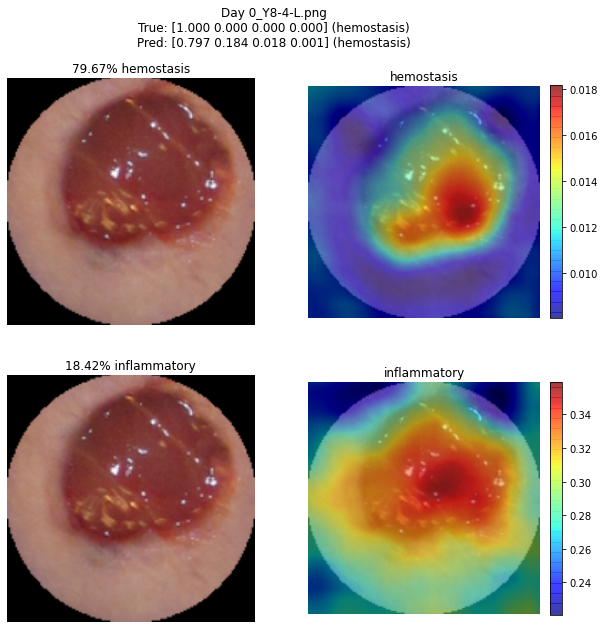

In [ ]:
test_images = ['Day 0_Y8-4-L.png', 'Day 11_Y8-4-L.png', 'Day 4_A8-1-R.png', 'Day 12_A8-1-R.png']
train_images = ['Day 3_Y8-3-L.png','Day 12_Y8-1-L.png', 'Day 6_A8-4-R.png','Day 14_A8-5-L.png']
image_name = test_images[0]
img_t = read_tensor(root_path + 'Circle_Cropped_images/' + image_name)
example(img_t, 2, image_name)

In [ ]:
random.sample(os.listdir(root_path + "Split_images/train"), 4)

['Day 14_Y8-2-L.png',
 'Day 3_Y8-2-L.png',
 'Day 1_A8-4-R.png',
 'Day 4_A8-4-L.png']

# Perturb Images

Perturbation Analysis on one image. Requires running a CMSF section and the "Linear Evaluation" section

In [ ]:
epoch = str(best_eval_epoch)

NameError: ignored

In [ ]:
# load model
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/model_best.pth.tar')
backbone = cpkt['backbone']
linear = cpkt['linear']

for p in backbone.parameters():
    p.requires_grad = False
for p in linear.parameters():
    p.requires_grad = False

model = lambda x: linear(backbone(x)).softmax(dim=1)

NameError: ignored

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])       
input_transf = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    normalize
])  

In [ ]:
def pred_perturb(transf, xs, plot_title):
    hemos, infla, proli, matur = [], [], [], [] 
    for x in xs:
        img_p = transf(img, x)
        pred = model(input_transf(img_p).unsqueeze(0)).cpu().numpy()
        hemos.append(pred[0][0])
        infla.append(pred[0][1])
        proli.append(pred[0][2])
        matur.append(pred[0][3])
    
    plt.plot(xs, hemos, label='Hemostatis')
    plt.plot(xs, infla, label='Inflammatory')
    plt.plot(xs, proli, label='Proliferative')
    plt.plot(xs, matur, label='Maturation')
    plt.title(plot_title)
    plt.legend()

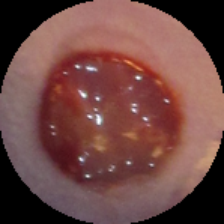

In [ ]:
# get image to perturb
test_images = ['Day 0_Y8-4-L.png', 'Day 11_Y8-4-L.png', 'Day 4_A8-1-R.png', 'Day 12_A8-1-R.png']
image_name = 'Day 0_A8-4-L.png'
img = Image.open(root_path + 'Circle_Cropped_images/' + image_name)

#print(model(input_transf(img).unsqueeze(0)))
transforms.Resize(224)(img)

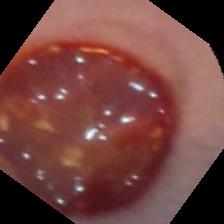

In [ ]:
    augmentation_strong = [
        transforms.RandomResizedCrop(224, scale=(0.5, 1.)),
        #transforms.Resize(224),
        #transforms.RandomApply([
        #    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        #], p=0.8),
        #transforms.RandomGrayscale(p=0.2),
        #transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(saturation=(0,1)),
        transforms.RandomRotation((0, 360)),
        #transforms.RandomAffine((0,0), translate=(0.3, 0.3)),
        #transforms.ToTensor(),
        #normalize
    ]
transforms.Compose(augmentation_strong)(img)

In [ ]:
sats = np.array(range(0, 101)) / 100
pred_perturb(TF.adjust_saturation, sats, 'Saturation')

In [ ]:
angles = list(range(0, 360))
pred_perturb(TF.rotate, angles, 'Rotation')

In [ ]:
hues = np.array(range(-50, 51)) / 100
pred_perturb(TF.adjust_hue, hues, 'Hue')

# Supervised CMSF

Modified from https://github.com/UMBCvision/CMSF/blob/main/supervised/train_sup_msf.py

Requires running the "Self-Supervised CMSF" section

### Setup

In [ ]:
class MeanShift(nn.Module):
    def __init__(self, arch, m=0.99, mem_bank_size=128000, topk=5, output_dim=16):
        super(MeanShift, self).__init__()

        # save parameters
        self.m = m
        self.mem_bank_size = mem_bank_size
        self.topk = topk

        # create encoders and projection layers
        # both encoders should have same arch
        if 'resnet' in arch:
            self.encoder_q = initialize_encoder(arch, output_dim)[0]
            self.encoder_t = initialize_encoder(arch, output_dim)[0]

        # prediction layer
        self.predict_q = get_mlp(output_dim, output_dim * 2, output_dim)

        # copy query encoder weights to target encoder
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data.copy_(param_q.data)
            param_t.requires_grad = False

        print("using mem-bank size {}".format(self.mem_bank_size))
        # setup queue (For Storing Random Targets)
        self.register_buffer('queue', torch.randn(self.mem_bank_size, output_dim))
        # normalize the queue embeddings
        self.queue = nn.functional.normalize(self.queue, dim=1)
        # initialize the labels queue (For Purity measurement)
        self.register_buffer('labels', -1*torch.ones(self.mem_bank_size).long())
        # setup the queue pointer
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_target_encoder(self):
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data = param_t.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def data_parallel(self):
        self.encoder_q = torch.nn.DataParallel(self.encoder_q)
        self.encoder_t = torch.nn.DataParallel(self.encoder_t)
        self.predict_q = torch.nn.DataParallel(self.predict_q)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, targets, labels):
        batch_size = targets.shape[0]

        ptr = int(self.queue_ptr)
        assert self.mem_bank_size % batch_size == 0 

        # replace the targets at ptr (dequeue and enqueue)
        self.queue[ptr:ptr + batch_size] = targets
        self.labels[ptr:ptr + batch_size] = labels
        ptr = (ptr + batch_size) % self.mem_bank_size  # move pointer

        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_t, labels, indices):
        # compute query features
        feat_q = self.encoder_q(im_q)
        # compute predictions for instance level regression loss
        query = self.predict_q(feat_q)
        query = nn.functional.normalize(query, dim=1)

        # compute target features
        with torch.no_grad():
            # update the target encoder
            self._momentum_update_target_encoder()

            # shuffle targets
            shuffle_ids, reverse_ids = get_shuffle_ids(im_t.shape[0])
            im_t = im_t[shuffle_ids]

            # forward through the target encoder
            current_target = self.encoder_t(im_t)
            current_target = nn.functional.normalize(current_target, dim=1)

            # undo shuffle
            current_target = current_target[reverse_ids].detach()
            self._dequeue_and_enqueue(current_target, labels)

        Q = query
        K = current_target
        M = self.queue.clone().detach()

        Lx = labels
        Lm = self.labels.clone().detach()

        b = Q.shape[0]
        m = M.shape[0]
        k = self.topk

        # 1. reshape labels to have same size
        Lx1 = Lx.unsqueeze(1).expand((b, m))
        Lm1 = Lm.unsqueeze(0).expand((b, m))
        Msk = Lx1 != Lm1

        # 2. calculate distances
        Dk = 2 - 2 * (K @ M.T)
        Dq = 2 - 2 * (Q @ M.T)

        # 3. set non category distances to 5 (max distance)
        Dk[torch.where(Msk)] = 5.0

        # 4. select indices of topk distances from Dk
        _, iNDk = Dk.topk(k, dim=1, largest=False)

        # 5. using above indices, gather the distances from Dq
        NDq = torch.gather(Dq, 1, iNDk)

        # 6. first, average over k, and then average over b
        L = NDq.mean(dim=1).mean()
        P = torch.gather(Lx1 == Lm1, 1, iNDk)
        purity = 100 * (torch.count_nonzero(P, dim=1) / k).mean()

        return L, purity

In [ ]:
def cmsf_main(data_path, checkpoint_path, label_fn, batch_size=16, num_workers=2, 
              epochs=200, print_freq=10, save_freq=10, weak_strong=True, 
              debug=False, arch='resnet', momentum=0.99, mem_bank_size=128000, 
              topk=5, learning_rate=0.05, sgd_momentum=0.9, weight_decay=1e-4, 
              weights=None, resume=None, restart=False, cos=True, lr_decay_rate=0.2, 
              lr_decay_epochs=[90,120], output_dim=16):
    opt = locals()
    del opt['label_fn']
    print(opt)

    if not resume and not weights:
        os.makedirs(checkpoint_path)

    train_loader = get_train_loader(data_path, label_fn, batch_size, num_workers, weak_strong)

    mean_shift = MeanShift(
        arch,
        m=momentum,
        mem_bank_size=mem_bank_size,
        topk=topk,
        output_dim=output_dim
    )
    mean_shift.data_parallel()
    mean_shift = mean_shift.cuda()
    print(mean_shift)

    print("Params to learn:")
    for name,param in mean_shift.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    params = [p for p in mean_shift.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params,
                                lr=learning_rate,
                                momentum=sgd_momentum,
                                weight_decay=weight_decay)

    cudnn.benchmark = True
    start_epoch = 1

    history_df = pd.DataFrame(index=range(start_epoch, epochs + 1))

    if weights:
        print('==> load weights from checkpoint: {}'.format(weights))
        ckpt = torch.load(weights)
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        if 'model' in ckpt:
            sd = ckpt['model']
        else:
            sd = ckpt['state_dict']
        msg = mean_shift.load_state_dict(sd, strict=False)
        optimizer.load_state_dict(ckpt['optimizer'])
        start_epoch = ckpt['epoch'] + 1
        history_df = ckpt['history_df']
        print(msg)

    if resume:
        print('==> resume from checkpoint: {}'.format(resume))
        ckpt = torch.load(resume)
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        mean_shift.load_state_dict(ckpt['state_dict'], strict=True)
        if not restart:
            optimizer.load_state_dict(ckpt['optimizer'])
            start_epoch = ckpt['epoch'] + 1
            history_df = ckpt['history_df']

    lr_args = LRArgs(cos, learning_rate, epochs, lr_decay_rate)

    # routine
    for epoch in range(start_epoch, epochs + 1):
        adjust_learning_rate(epoch, lr_args, optimizer)
        print("==> training...")

        time1 = time.time()
        loss, purity = train(epoch, train_loader, mean_shift, optimizer, print_freq)

        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        history_df.loc[epoch, 'loss'] = loss
        history_df.loc[epoch, 'purity'] = purity

        # saving the model
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'opt': opt,
                'state_dict': mean_shift.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'history_df': history_df
            }

            save_file = os.path.join(checkpoint_path, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

            # help release GPU memory
            del state
            torch.cuda.empty_cache()

### Folder to store outputs and number of epochs to run

In [ ]:
train_folder_name = 'supervised_finals/1_ww/'
epochs = 200

# Supervised CMSF Training

Edit the last cell of the previous section to control the output folder. 

Model can be evaluated with the "Linear Evaluation", "Test Set", and "KNN Evaluation" sections just as with the self-supervised model

In [ ]:
cmsf_main(
    data_path=root_path + 'Split_images', 
    checkpoint_path=root_path + 'outputs/' + train_folder_name, 
    label_fn=lambda x: labels_map[x],
    batch_size=8,
    num_workers=2,
    epochs=epochs,
    arch='resnet_healnet',
    topk=10,
    learning_rate=0.05,
    cos=True,
    mem_bank_size=128000,
    weak_strong=True,
    output_dim=16,
    debug=False)

{'data_path': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'checkpoint_path': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/supervised_finals/2_ws/', 'batch_size': 8, 'num_workers': 2, 'epochs': 200, 'print_freq': 10, 'save_freq': 10, 'weak_strong': True, 'debug': False, 'arch': 'resnet_healnet', 'momentum': 0.99, 'mem_bank_size': 128000, 'topk': 10, 'learning_rate': 0.05, 'sgd_momentum': 0.9, 'weight_decay': 0.0001, 'weights': None, 'resume': None, 'restart': False, 'cos': True, 'lr_decay_rate': 0.2, 'lr_decay_epochs': [90, 120], 'output_dim': 16}
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolati

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


using mem-bank size 128000
MeanShift(
  (encoder_q): DataParallel(
    (module): ResnetEncoder(
      (embed_model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2

# Semi-Supervised CMSF

Mostly modified form https://github.com/UMBCvision/CMSF/tree/main/semi_supervised

Requires running the "Self-Supervised CMSF" section

### Data Loaders

In [ ]:
class Pseudo_Image_Dataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, label_fn, only_sup=False, transform=None):
        """
        Image dataset for semi-supervised. Returns tensorized images and labels with index
        Args:
            root_dir: path to a cropped mouse image dataset.
            label_fn: function that returns the correct label given an image name, should
                      return tuple (true_label, is_unsupervised) if no label
            only_sup: whether to use only labeled images
        """
        self.root_dir = root_dir
        self.label_fn = label_fn
        self.transform = transform

        samples = []
        targets = []
        is_unsups = []
        for f in os.listdir(root_dir):
            target, is_unsup = label_fn(f)
            if not (only_sup and is_unsup):
                samples.append(os.path.join(root_dir, f))
                targets.append(target)
                is_unsups.append(is_unsup)
        
        self.samples = samples
        self.targets = targets
        self.is_unsups = is_unsups

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
            """
            Returns index, tensor data, tensorized label, and if the image is unlabeled
            """
            img = self.pil_loader(self.samples[index])
            target = self.targets[index]
            is_unsup = self.is_unsups[index]

            if self.transform:
                img = self.transform(img)

            return index, img, torch.tensor(target), is_unsup

    def __len__(self):
        return len(self.samples)

    def __str__(self):
        return "Image_Dataset:\n" + "Found " + str(len(self)) + " images in " + self.root_dir + "\n"

In [ ]:
def get_pseudo_train_loader(data, weak_strong, label_fn, batch_size, num_workers):
    traindir = os.path.join(data, 'train')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)

    augmentation_strong = [
        transforms.RandomResizedCrop(224, scale=(0.5, 1.)),
        #transforms.Resize(224),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        #transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(saturation=(0,1)),
        transforms.RandomRotation((0, 360)),
        #transforms.RandomAffine((0,0), translate=(0.3, 0.3)),
        transforms.ToTensor(),
        normalize
    ]

    augmentation_weak = [
        transforms.RandomResizedCrop(224, scale=(0.5, 1.)),
        #transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((0, 360)),
        transforms.ToTensor(),
        normalize,
    ]

    if weak_strong:
        train_dataset = Pseudo_Image_Dataset(
            traindir,
            label_fn,
            False,
            TwoCropsTransform(transforms.Compose(augmentation_weak), transforms.Compose(augmentation_strong))
        )
    else:
        train_dataset = Pseudo_Image_Dataset(
            traindir,
            label_fn,
            False,
            TwoCropsTransform(transforms.Compose(augmentation_weak), transforms.Compose(augmentation_weak))
        )

    print('==> train dataset')
    print(train_dataset)

    # NOTE: remove drop_last
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True)

    # Get dataloader for pseudo-labelling
    sup_val_dataset = Pseudo_Image_Dataset(traindir, label_fn, True, transforms.Compose(augmentation_weak))
    train_val_loader = torch.utils.data.DataLoader(
        sup_val_dataset,
        batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True,
    )

    return train_loader, train_val_loader

### Architecture

In [ ]:
def get_mlp_3l(inp_dim, hidden_dim_1, hidden_dim_2, out_dim):
    """Returns a two-layer MLP; used for classifier.
    """
    mlp = nn.Sequential(
        nn.Linear(inp_dim, hidden_dim_1),
        nn.BatchNorm1d(hidden_dim_1),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim_1, hidden_dim_2),
        nn.BatchNorm1d(hidden_dim_2),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim_2, out_dim),
    )
    return mlp

In [ ]:
class PseudoCMSF(nn.Module):
    def __init__(self, arch, mlp_xent, m=0.99, mem_bank_size=128000, topk=5, ncls=1000, 
                 output_dim=16, topk_lbl=1, use_conf=True, conf_th=0.8, sup_mem_bank_size=128000, 
                 cache_sup=True, cache_conf_unsup=True):
        super(PseudoCMSF, self).__init__()

        # save parameters
        self.m = m
        self.mem_bank_size = mem_bank_size
        self.topk = topk

        # additional parameters for pseudo-labeled constrained mean shift
        self.topk_lbl = topk_lbl
        self.use_conf = use_conf
        self.conf_th = conf_th
        self.sup_mem_bank_size = sup_mem_bank_size
        self.cache_sup = cache_sup
        self.cache_conf_unsup = cache_conf_unsup

        if self.topk_lbl > 1:
            sys.exit('Not Implemented!!!')
            
        # create encoders and projection layers
        # both encoders should have same arch
        self.encoder_q = initialize_encoder(arch, output_dim)[0]
        self.encoder_t = initialize_encoder(arch, output_dim)[0]

        # prediction layer
        self.predict_q = get_mlp(output_dim, output_dim * 2, output_dim)

        # mlp head to perform pseudo-labeling
        if mlp_xent == 'linear':
            self.mlp_head = nn.Sequential(
                # FullBatchNorm(train_var, train_mean),
                nn.Linear(output_dim, ncls),
            )
        elif mlp_xent == 'mlp':
            self.mlp_head = get_mlp(output_dim, 2 * output_dim, ncls)
        elif mlp_xent == 'mlp_3l':
            self.mlp_head = get_mlp_3l(output_dim, 2 * output_dim, 2 * output_dim, ncls)

        # copy query encoder weights to target encoder
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data.copy_(param_q.data)
            param_t.requires_grad = False

        print("using mem-bank size {}".format(self.mem_bank_size))
        # setup queue (For Storing Random Targets)
        self.register_buffer('queue', torch.randn(self.mem_bank_size, output_dim))
        # normalize the queue embeddings
        self.queue = nn.functional.normalize(self.queue, dim=1)
        # initialize the labels queue (For constrained mean shift - use pseudo labels)
        self.register_buffer('labels', -1*torch.ones(self.mem_bank_size).long())
        # setup the queue pointer
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))

        # initialize the ground truth labels queue (For Purity measurement)
        self.register_buffer('gt_labels', -1 * torch.ones(self.mem_bank_size).long())

        if self.cache_sup:
            # Queue for features and labels of supervised set (and possibly highly confident unsupervised set) - caching
            # these features makes xent pseudo-label training faster
            # setup queue (For Storing Supervised Targets)
            self.register_buffer('sup_queue', torch.randn(self.sup_mem_bank_size, output_dim))
            # normalize the queue embeddings
            self.sup_queue = nn.functional.normalize(self.sup_queue, dim=1)
            # initialize the supervised labels queue
            self.register_buffer('sup_labels', -1 * torch.ones(self.sup_mem_bank_size).long())
            # setup the supervised queue pointer
            self.register_buffer('sup_queue_ptr', torch.zeros(1, dtype=torch.long))
            self.register_buffer('sup_queue_oflow', torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_target_encoder(self):
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data = param_t.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def data_parallel(self):
        self.encoder_q = torch.nn.DataParallel(self.encoder_q)
        self.encoder_t = torch.nn.DataParallel(self.encoder_t)
        self.predict_q = torch.nn.DataParallel(self.predict_q)
        self.mlp_head = torch.nn.DataParallel(self.mlp_head)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, targets, labels, gt_labels):
        batch_size = targets.shape[0]

        ptr = int(self.queue_ptr)
        assert self.mem_bank_size % batch_size == 0

        # replace the targets at ptr (dequeue and enqueue)
        self.queue[ptr:ptr + batch_size] = targets
        self.labels[ptr:ptr + batch_size] = labels
        self.gt_labels[ptr:ptr + batch_size] = gt_labels
        ptr = (ptr + batch_size) % self.mem_bank_size  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _sup_dequeue_and_enqueue(self, targets, labels):
        batch_size = targets.shape[0]

        ptr = int(self.sup_queue_ptr)

        # sup_mem_bank_size need not be a multiple of batch size.
        # if all sup data points won't fit in the queue
        # we slide back the pointer to accommodate them
        if (ptr + batch_size) > self.sup_mem_bank_size:
            ptr = self.sup_mem_bank_size - batch_size
            self.sup_queue_oflow[0] = 1

        # replace the targets at ptr (dequeue and enqueue)
        self.sup_queue[ptr:ptr + batch_size] = targets
        self.sup_labels[ptr:ptr + batch_size] = labels
        ptr = (ptr + batch_size) % self.sup_mem_bank_size  # move pointer

        self.sup_queue_ptr[0] = ptr

    @torch.no_grad()
    def _pseudo_label(self, feat_t, feat_q):
        # pseudo-label prediction
        output_t = self.mlp_head(feat_t)
        prob = F.softmax(output_t, -1)
        pred = torch.argmax(prob, dim=1)
        prob_topk, pred_topk = prob.topk(4)
        return pred, pred_topk, prob_topk

    def forward(self, im_q, im_t, gt_labels, is_unsup):
        # compute query features
        feat_q = self.encoder_q(im_q)
        # compute predictions for instance level regression loss
        query = self.predict_q(feat_q)
        query = nn.functional.normalize(query, dim=1)

        # compute target features
        with torch.no_grad():
            # update the target encoder
            self._momentum_update_target_encoder()

            # shuffle targets
            shuffle_ids, reverse_ids = get_shuffle_ids(im_t.shape[0])
            im_t = im_t[shuffle_ids]

            # forward through the target encoder
            current_target = self.encoder_t(im_t)
            current_target = nn.functional.normalize(current_target, dim=1)

            # undo shuffle
            current_target = current_target[reverse_ids].detach()

            # Calculate pseudo labels
            pseudo_labels, pseudo_labels_topk, prob_topk = self._pseudo_label(current_target, query)

            # Replace pseudo-labels with gt labels for supervised set
            sup_idx = torch.where(is_unsup == 0)
            unsup_idx = torch.where(is_unsup == 1)
            pseudo_labels_topk[sup_idx[0], 0] = gt_labels[sup_idx]
            assert torch.all(pseudo_labels_topk[sup_idx[0], 0] == gt_labels[sup_idx])

            # If using confidence, set the labels of samples with conf < thresh to -1
            if self.use_conf:
                not_conf = torch.lt(prob_topk[:, 0], self.conf_th)
                # Supervised samples are set to confident
                not_conf[sup_idx] = False
                not_conf_idx = torch.where(not_conf)
                # conf_idx ==> idx of supervised and highly confident unsupervised samples
                conf_idx = torch.where(~not_conf)
                pseudo_labels_topk[not_conf_idx] = -1

            self._dequeue_and_enqueue(current_target, pseudo_labels_topk[:, 0], gt_labels)
            if self.cache_sup:
                if self.cache_conf_unsup:
                    # Cache both supervised and highly confident unsupervised samples
                    self._sup_dequeue_and_enqueue(current_target[conf_idx], pseudo_labels_topk[conf_idx][:, 0])
                else:
                    # Cache only supervised samples
                    self._sup_dequeue_and_enqueue(current_target[sup_idx], gt_labels[sup_idx])
                    
            # The top-k labels below threshold confidence must not participate in constraint calculation. Since the
            # label -1 is part of target memory bank labels, set the labels for non-confidant samples to -2.
            if self.use_conf:
                pseudo_labels_topk[not_conf_idx] = -2
                # pseudo_labels_topk[not_conf_idx[0], not_conf_idx[1]] = -2

        Q = query
        K = current_target
        M = self.queue.clone().detach()

        # Regardless of self.topk_lbl, pseudo_labels_topk is always set to [bs, 5] for easier purity calculation.
        # Select top-k pseudo-labels for query batch and target memory bank
        Lx = pseudo_labels_topk[:, :self.topk_lbl]
        Lm = self.labels.clone().detach()
        Lx_gt = gt_labels
        Lm_gt = self.gt_labels.clone().detach()

        b = Q.shape[0]
        m = M.shape[0]
        k = self.topk
        k2 = self.topk_lbl

        # 1. reshape labels to have same size (tile/copy labels to the expanded dim)
        Lx1 = Lx.unsqueeze(1).expand((b, m, k2))
        Lm1 = Lm.unsqueeze(0).unsqueeze(2).expand((b, m, k2))
        # Mask is 1 if none of q-top-k labels in query is present in any of t-top-k labels in target
        # i.e, mask=1 implies the target sample is from a different class compared to query
        Msk = torch.all(Lx1 != Lm1, dim=-1)
        if self.use_conf:
            # If none of the top-k pseudo-labels for a sample is confident, fallback to msf loss
            Msk[not_conf_idx] = False

        # reshape gt labels; used in purity calculation
        Lx1_gt = Lx_gt.unsqueeze(1).expand((b, m))
        Lm1_gt = Lm_gt.unsqueeze(0).expand((b, m))

        # 2. calculate distances
        Dk = 2 - 2 * (K @ M.T)
        Dq = 2 - 2 * (Q @ M.T)

        # top-k indices from Dk without class constraint (plain mean shift)
        _, iNDk_msf = Dk.topk(k, dim=1, largest=False)

        # 3. set non category distances to 5 (max distance)
        Dk[torch.where(Msk)] = 5.0

        # 4. select indices of topk distances from Dk
        _, iNDk = Dk.topk(k, dim=1, largest=False)

        # 5. using above indices, gather the distances from Dq
        NDq = torch.gather(Dq, 1, iNDk)

        # 6. first, average over k, and then average over b
        L = NDq.mean(dim=1).mean()

        # calculate purity, based on true labels for unsupervised set
        P = torch.gather(Lx1_gt == Lm1_gt, 1, iNDk)
        purity = 100 * (P.float().sum(dim=1) / k).mean()

        # purity of top-k neighbours without constraint --> purity of simple mean shift
        P = torch.gather(Lx1_gt == Lm1_gt, 1, iNDk_msf)
        purity_msf = 100 * (P.float().sum(dim=1) / k).mean()

        # calculate accuracy of pseudo-labelling (remove supervised set from pseudo-labels)
        if not self.use_conf:
            acc = (gt_labels[unsup_idx] == pseudo_labels_topk[unsup_idx[0], 0]).float().mean()
            acc_topk = torch.eq(pseudo_labels_topk[unsup_idx],
                                gt_labels[unsup_idx].unsqueeze(1).expand((-1, 4))).float()
            acc_topk = acc_topk.sum(dim=1).mean()
        else:
            # Do not consider non-confident labels for purity calculation
            acc_topk = torch.eq(pseudo_labels_topk[unsup_idx],
                                gt_labels[unsup_idx].unsqueeze(1).expand((-1, 4))).float()
            # acc is considered 0 where lbl is not confident. however, they are ignored by summing over only the
            # confident ones.
            acc_topk[:, 0] = acc_topk[:, 0] * (~not_conf[unsup_idx] * 1.)
            acc = acc_topk[:, 0].sum() / ((~not_conf[unsup_idx] * 1.).sum() + 1e-6)
            acc_topk = acc_topk.mean()
        acc *= 100.
        acc_topk *= 100.

        return L, purity, purity_msf, acc, acc_topk, prob_topk

### Misc Functions

In [ ]:
def get_feats(model, loader, print_freq=10):
    """Obtain features and labels for all samples in data loader using current model.
    """
    batch_time = AverageMeterV2('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, ptr = None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (_, images, target, _) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = normalize(model(images)).cpu()
            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets)
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels

### Training Functions

In [ ]:
def train_pseudo_lbl(pseudo_cmsf, train_val_loader, backbone, model, cache_sup,
                     print_freq, cache_conf_unsup, pseudo_lbl_lr, pseudo_lbl_momentum,
                     pseudo_lbl_weight_decay, pseudo_lbl_lr_schedule, pseudo_lbl_epochs, 
                     pseudo_batch_size):
    """Train pseudo-labeling model (mlp) till convergence.
    """
    # switch to train mode
    backbone.eval()
    model.train()

    if not cache_sup:
        # Get features for all samples if they were not cached during CMSF training
        train_feats, train_labels = get_feats(backbone, train_val_loader, print_freq)
    else:
        # Load features cached during CMSF training epoch
        train_feats = pseudo_cmsf.sup_queue.clone().detach()
        train_labels = pseudo_cmsf.sup_labels.clone().detach()
        # sup_mem_bank_size >> len(sup_set) + len(high_conf_unsup_set) when unsup is also being cached. Select only
        # till the queue pointer, remaining features are not meaningful.
        if (pseudo_cmsf.sup_queue_oflow == 0) and cache_conf_unsup:
            train_feats = train_feats[:pseudo_cmsf.sup_queue_ptr]
            train_labels = train_labels[:pseudo_cmsf.sup_queue_ptr]
        print('Num samples for pseudo-label training: {:d}'.format(len(train_labels)))

    # Create a new optimizer to train the MLP classifier for each round of pseudo-label training since the optim
    # parameters would need to be reset at the end of each round.
    optimizer = torch.optim.SGD(model.parameters(),
                                pseudo_lbl_lr,
                                momentum=pseudo_lbl_momentum,
                                weight_decay=pseudo_lbl_weight_decay)

    sched = [int(x) for x in pseudo_lbl_lr_schedule.split(',')]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=sched
    )
    for epoch in range(pseudo_lbl_epochs):

        batch_time = AverageMeterV2('Time', ':6.3f')
        data_time = AverageMeterV2('Data', ':6.3f')
        losses = AverageMeterV2('Loss', ':.4e')
        top1 = AverageMeterV2('Acc@1', ':6.2f')
        top2 = AverageMeterV2('Acc@2', ':6.2f')
        progress = ProgressMeter(
            len(train_feats)//pseudo_batch_size,
            [batch_time, data_time, losses, top1, top2],
            prefix="Epoch: [{}]".format(epoch))

        end = time.time()
        # for i, (images, target) in enumerate(train_loader):
        n_batches = len(train_feats) // pseudo_batch_size
        indices = torch.arange(len(train_feats))
        perm = torch.randperm(len(train_feats))
        indices = indices[perm]
        # for i, idx in enumerate(indices):
        for idx in range(n_batches):
            # measure data loading time
            data_time.update(time.time() - end)

            ids = indices[(idx * pseudo_batch_size): (idx + 1) * pseudo_batch_size]
            if cache_sup:
                output = train_feats[ids]
                target = train_labels[ids]
                # Some labels in queue might be set to -1 in first epoch
                target[target == -1] = 0
            else:
                output = train_feats[ids].cuda()
                target = train_labels[ids].cuda()
            output = model(output)
            loss = F.cross_entropy(output, target)

            # measure accuracy and record loss
            acc1, acc2 = accuracy(output, target, topk=(1, 2))
            losses.update(loss.item(), ids.size(0))
            top1.update(acc1[0], ids.size(0))
            top2.update(acc2[0], ids.size(0))

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            #if idx % print_freq == 0:
            #    print(progress.display(idx))

        lr_scheduler.step()

In [ ]:
def fill_mem_bank(pseudo_cmsf, train_loader):

    print('Filling up supervised and unsupervised memory banks')
    for idx, (indices, (im_q, im_t), labels, is_unsup) in enumerate(train_loader):
        if idx % 10 == 0:
            print(idx)

        im_q = im_q.cuda(non_blocking=True)
        im_t = im_t.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        # ===================forward=====================
        _ = pseudo_cmsf(im_q=im_q, im_t=im_t, gt_labels=labels, is_unsup=is_unsup)

        del _

    return 0

In [ ]:
def train(epoch, train_loader, pseudo_cmsf, optimizer, train_pseudo_loader, batch_size, 
          cache_sup, print_freq, cache_conf_unsup, pseudo_lbl_lr, pseudo_lbl_momentum,
          pseudo_lbl_weight_decay, pseudo_lbl_lr_schedule, pseudo_lbl_epochs, pseudo_batch_size):
    """
    one epoch training
    """
    pseudo_cmsf.train()
    pseudo_cmsf.mlp_head.eval()

    batch_time = AvgMeter()
    data_time = AvgMeter()
    loss_meter = AvgMeter()
    purity_meter = AvgMeter()
    purity_msf_meter = AvgMeter()
    acc_pseudo_meter = AvgMeter()
    acc_topk_pseudo_meter = AvgMeter()

    end = time.time()
    for idx, (indices, (im_q, im_t), labels, is_unsup) in enumerate(train_loader):
        if (idx == len(train_loader) // 2) and (batch_size < 1024):
            train_pseudo_lbl(pseudo_cmsf, train_pseudo_loader, pseudo_cmsf.encoder_t, pseudo_cmsf.mlp_head, 
                             cache_sup, print_freq, cache_conf_unsup, pseudo_lbl_lr, pseudo_lbl_momentum,
                             pseudo_lbl_weight_decay, pseudo_lbl_lr_schedule, pseudo_lbl_epochs, 
                             pseudo_batch_size)
            pseudo_cmsf.train()
            pseudo_cmsf.mlp_head.eval()

        data_time.update(time.time() - end)
        im_q = im_q.cuda(non_blocking=True)
        im_t = im_t.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        # ===================forward=====================
        loss, purity, purity_msf, acc_pseudo, acc_topk_pseudo, prob_topk = pseudo_cmsf(
            im_q=im_q, im_t=im_t, gt_labels=labels, is_unsup=is_unsup)

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        loss_meter.update(loss.item(), im_q.size(0))
        purity_meter.update(purity.item(), im_q.size(0))
        purity_msf_meter.update(purity_msf.item(), im_q.size(0))
        acc_pseudo_meter.update(acc_pseudo.item(), im_q.size(0))
        acc_topk_pseudo_meter.update(acc_topk_pseudo.item(), im_q.size(0))

        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t'
                  'purity {purity.val:.3f} ({purity.avg:.3f})\t'
                  'purity-msf {purity_msf.val:.3f} ({purity_msf.avg:.3f})\t'
                  'acc-pseudo {acc_pseudo.val:.3f} ({acc_pseudo.avg:.3f})\t'
                  'acc-topk-pseudo {acc_topk_pseudo.val:.3f} ({acc_topk_pseudo.avg:.3f})\t'
                  .format(
                   epoch, idx + 1, len(train_loader),
                   batch_time=batch_time,
                   data_time=data_time,
                   purity=purity_meter,
                   purity_msf=purity_msf_meter,
                   acc_pseudo=acc_pseudo_meter,
                   acc_topk_pseudo=acc_topk_pseudo_meter,
                   loss=loss_meter,
                   ))
            sys.stdout.flush()
            sys.stdout.flush()

    return loss_meter.avg, purity_meter.avg

In [ ]:
def semi_sup_main(data_path, checkpoint_path, arch, label_fn, ncls=4, mlp_xent='mlp_3l', momentum=0.99,
                  mem_bank_size=128000, topk=5, output_dim=16, topk_lbl=1, use_conf=True, 
                  conf_th=0.8, sup_mem_bank_size=128000, cache_sup=True, cache_conf_unsup=True,
                  learning_rate=0.01, sgd_momentum=0.9, weight_decay=1e-4, resume=None, 
                  restart=False, epochs=200, cos=True, lr_decay_rate=0.2, batch_size=8,
                  print_freq=10, pseudo_lbl_lr=0.01, pseudo_lbl_momentum=0.9, pseudo_lbl_weight_decay=1e-4, 
                  pseudo_lbl_lr_schedule='15,30,40', pseudo_lbl_epochs=40, pseudo_batch_size=8, 
                  weak_strong=True, num_workers=2, save_freq=10):
    """
    mlp_xent choices: ['linear', 'mlp', 'mlp_3l']
    """
    opt = locals()
    del opt['label_fn']

    os.makedirs(checkpoint_path, exist_ok=False)

    print(opt)

    train_loader, train_pseudo_loader = get_pseudo_train_loader(data_path, weak_strong, label_fn, batch_size, num_workers)

    pseudo_cmsf = PseudoCMSF(
        arch, mlp_xent, momentum, mem_bank_size, topk, ncls, output_dim, topk_lbl, 
        use_conf, conf_th, sup_mem_bank_size, cache_sup, cache_conf_unsup
    )
    pseudo_cmsf.data_parallel()
    pseudo_cmsf = pseudo_cmsf.cuda()
    print(pseudo_cmsf)

    params = [p for p in pseudo_cmsf.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params,
                                lr=learning_rate,
                                momentum=sgd_momentum,
                                weight_decay=weight_decay)

    cudnn.benchmark = True
    start_epoch = 1

    history_df = pd.DataFrame(index=range(start_epoch, epochs + 1))

    if resume:
        print('==> resume from checkpoint: {}'.format(resume))
        ckpt = torch.load(resume)
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        sd = ckpt['state_dict']
        pseudo_cmsf.load_state_dict(sd, strict=True)
        if not restart:
            optimizer.load_state_dict(ckpt['optimizer'])
            start_epoch = ckpt['epoch'] + 1
            history_df = ckpt['history_df']
            # Used when memory bank is not loaded. Fill up memory bank before starting training
            # fill_mem_bank(pseudo_cmsf, train_loader, args)

    lr_args = LRArgs(cos, learning_rate, epochs, lr_decay_rate)
        

    # routine
    for epoch in range(start_epoch, epochs + 1):

        adjust_learning_rate(epoch, lr_args, optimizer)
        print("==> training...")

        # sup_mem_bank_size >> len(sup_set) + len(high_conf_unsup_set) when unsup is also being cached. Set pointer
        # to 0 at the start of each epoch and use features till the queue pointer at the end of epoch for
        # pseudo-label training
        if cache_sup:
            pseudo_cmsf.sup_queue_oflow[0] = 0
            if cache_conf_unsup:
                pseudo_cmsf.sup_queue_ptr[0] = 0

        time1 = time.time()
        # One epoch of Pseudo-CMSF training
        loss, purity = train(epoch, train_loader, pseudo_cmsf, optimizer, train_pseudo_loader, batch_size, 
                  cache_sup, print_freq, cache_conf_unsup, pseudo_lbl_lr, pseudo_lbl_momentum,
                  pseudo_lbl_weight_decay, pseudo_lbl_lr_schedule, pseudo_lbl_epochs, pseudo_batch_size)

        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        # One round of pseudo-label network training (one round = 10 epochs)
        train_pseudo_lbl(pseudo_cmsf, train_pseudo_loader, pseudo_cmsf.encoder_t, pseudo_cmsf.mlp_head, 
                         cache_sup, print_freq, cache_conf_unsup, pseudo_lbl_lr, pseudo_lbl_momentum,
                         pseudo_lbl_weight_decay, pseudo_lbl_lr_schedule, pseudo_lbl_epochs, 
                         pseudo_batch_size)
        time3 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time3 - time2))

        history_df.loc[epoch, 'loss'] = loss
        history_df.loc[epoch, 'purity'] = purity

        # saving the model
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'opt': opt,
                'state_dict': pseudo_cmsf.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'history_df': history_df
            }

            save_file = os.path.join(checkpoint_path, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

            # help release GPU memory
            del state
            torch.cuda.empty_cache()

### Getting Labels

In [ ]:
labels_df = pd.read_csv(root_path + 'Cleaned_Wound_Stage_Labels.csv', index_col='Image')
#labels_df['label'] = labels_df.index.map(lambda x: labels_df.loc[x].argmax())
labels_df.head()

hemostasis  inflammatory  proliferative  maturation  label
Image                                                                        
Day 8_A8-4-L.png     0.181818      0.090909       0.545455    0.181818      2
Day 4_A8-3-R.png     0.090909      0.909091       0.000000    0.000000      1
Day 14_Y8-4-L.png    0.000000      0.000000       0.090909    0.909091      3
Day 7_Y8-4-L.png     0.000000      0.000000       0.454545    0.545455      2
Day 2_A8-1-L.png     0.181818      0.727273       0.090909    0.000000      1

In [ ]:
l = [np.argmax(labels_df.loc[x, ['hemostasis','inflammatory','proliferative','maturation']]) for x in labels_df.index]
t = np.array(l) != labels_df.label
# maximum probabilities of labels that were changed in cleaning, confidence level for labels in semi-sup should be higher
labels_df.loc[t, ['hemostasis','inflammatory','proliferative','maturation']].max()

hemostasis       0.600000
inflammatory     0.600000
proliferative    0.600000
maturation       0.545455
dtype: float64

In [ ]:
# num of training images for each label
labels_df[np.array(labels_df.index.map(lambda x: x.split('_')[1] != 'Y8-4-L.png' and x.split('_')[1] != 'Y8-4-R.png' and x.split('_')[1] != 'A8-1-L.png' and x.split('_')[1] != 'A8-1-R.png'))].groupby('label')['label'].count()

label
0    40
1    40
2    62
3    49
Name: label, dtype: int64

In [ ]:
# anchors = ['Day 0_A8-4-L.png', 'Day 1_A8-3-R.png', 'Day 0_A8-5-L.png', 'Day 0_Y8-3-L.png', # hemo
#            'Day 0_Y8-1-R.png', 'Day 0_A8-4-R.png', 'Day 0_Y8-3-R.png', 'Day 0_A8-5-R.png', 
#            'Day 0_Y8-1-L.png', 'Day 0_Y8-2-L.png', 'Day 0_A8-3-L.png', 'Day 0_Y8-2-R.png',
#            'Day 4_A8-4-L.png', 'Day 4_A8-3-R.png', 'Day 3_A8-5-L.png', 'Day 4_Y8-1-R.png', # inflamm
#            'Day 5_A8-4-R.png', 'Day 5_Y8-3-R.png', 'Day 3_A8-5-R.png', 'Day 4_Y8-1-L.png', 
#            'Day 6_Y8-2-L.png', 'Day 3_A8-3-L.png', 'Day 4_Y8-2-R.png'
#            'Day 10_A8-4-L.png', 'Day 10_A8-3-R.png', 'Day 10_A8-5-L.png', 'Day 7_Y8-3-L.png', # prolif
#            'Day 7_Y8-1-R.png', 'Day 10_A8-4-R.png', 'Day 7_Y8-3-R.png', 'Day 8_A8-5-R.png', 
#            'Day 9_Y8-1-L.png', 'Day 10_Y8-2-L.png', 'Day 9_A8-3-L.png', 'Day 6_Y8-2-R.png',
#            'Day 15_A8-4-L.png', 'Day 14_A8-3-R.png', 'Day 14_Y8-3-L.png', 'Day 14_Y8-1-R.png', # matur
#            'Day 15_A8-4-R.png', 'Day 11_Y8-3-R.png', 'Day 13_A8-5-R.png', 'Day 11_Y8-1-L.png', 
#            'Day 13_Y8-2-L.png', 'Day 10_Y8-2-R.png']
# unconf_labels = labels_df.index.map(lambda x: x not in anchors).to_numpy(dtype=bool)

# def unconf_index_map(name):
#     max_prob = max(labels_df.loc[name, ['hemostasis','inflammatory','proliferative','maturation']])
#     if labels_df.loc[name, 'label'] == 0:
#         return max_prob < 0.9
#     elif labels_df.loc[name, 'label'] == 1:
#         return max_prob < 0.72
#     elif labels_df.loc[name, 'label'] == 2:
#         return max_prob < 0.8
#     else:
#         return max_prob < 1
# unconf_labels = np.array(labels_df.index.map(unconf_index_map), dtype=bool)

confidence = 0.75
unconf_labels = np.array([max(labels_df.loc[x, ['hemostasis','inflammatory','proliferative','maturation']]) for x in labels_df.index]) < confidence

# confident training lebels
conf_df = labels_df.loc[~unconf_labels, :]
conf_df[np.array(conf_df.index.map(lambda x: x.split('_')[1] != 'Y8-4-L.png' and x.split('_')[1] != 'Y8-4-R.png' and x.split('_')[1] != 'A8-1-L.png' and x.split('_')[1] != 'A8-1-R.png'))].groupby('label')['label'].count()

label
0    22
1     4
2    14
3    38
Name: label, dtype: int64

In [ ]:
labels_df['label'] = list(zip(labels_df.label, unconf_labels))
pseudo_labels_map = labels_df['label']
pseudo_labels_map.head()

Image
Day 8_A8-4-L.png      (2, True)
Day 4_A8-3-R.png     (1, False)
Day 14_Y8-4-L.png    (3, False)
Day 7_Y8-4-L.png      (2, True)
Day 2_A8-1-L.png      (1, True)
Name: label, dtype: object

### Output folder and epochs

In [ ]:
train_folder_name = 'semi_supervised_finals/2_ws/'
epochs = 200

# Semi-Supervised CMSF Training

Edit the last cell of the previous section to control the output folder. 

Model can be evaluated with the "Linear Evaluation", "Test Set", and "KNN Evaluation" sections just as with the self-supervised model

In [ ]:
semi_sup_main(
    data_path=root_path + 'Split_images', 
    checkpoint_path=root_path + 'outputs/' + train_folder_name, 
    label_fn=lambda x: pseudo_labels_map[x],
    num_workers=2,
    epochs=epochs,
    arch='resnet_healnet',
    batch_size=8,
    learning_rate=0.05,
    mem_bank_size=128000,
    topk=10,
    weak_strong=True,
    output_dim=16,
    use_conf=True,
    conf_th=confidence,
    pseudo_lbl_epochs=20,
    mlp_xent='mlp_3l')

{'data_path': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'checkpoint_path': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/semi_supervised_finals/2_ws/', 'arch': 'resnet_healnet', 'ncls': 4, 'mlp_xent': 'mlp_3l', 'momentum': 0.99, 'mem_bank_size': 128000, 'topk': 10, 'output_dim': 16, 'topk_lbl': 1, 'use_conf': True, 'conf_th': 0.75, 'sup_mem_bank_size': 128000, 'cache_sup': True, 'cache_conf_unsup': True, 'learning_rate': 0.05, 'sgd_momentum': 0.9, 'weight_decay': 0.0001, 'resume': None, 'restart': False, 'epochs': 200, 'cos': True, 'lr_decay_rate': 0.2, 'batch_size': 8, 'print_freq': 10, 'pseudo_lbl_lr': 0.01, 'pseudo_lbl_momentum': 0.9, 'pseudo_lbl_weight_decay': 0.0001, 'pseudo_lbl_lr_schedule': '15,30,40', 'pseudo_lbl_epochs': 20, 'pseudo_batch_size': 8, 'weak_strong': True, 'num_workers': 2, 'save_freq': 10}
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


using mem-bank size 128000
PseudoCMSF(
  (encoder_q): DataParallel(
    (module): ResnetEncoder(
      (embed_model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv

# Baseline CNN Training

Trains the baseline classifier on just the pretrained HealNet encoder, no CMSF.

Requires running the "Self-Supervised CMSF" and "Linear Evaluation" sections.

In [ ]:
output_folder_name = 'baseline_finals/1_healnet/'

### Training

In [ ]:
_, _ = main_linear_eval(
        data=root_path + 'Split_images', 
        label_fn=lambda x: labels_df.loc[x].to_numpy(), 
        weights=None,
        save=root_path + 'outputs/' + output_folder_name, 
        batch_size=8, 
        lr=0.01,
        epochs=40, 
        mlp=False,
        workers=2, 
        arch='resnet_healnet_pretr', 
        print_freq=10,  
        output_dim=16)

logger_init



{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': None, 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/baseline_finals/1_healnet/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet_pretr', 'print_freq': 10, 'mlp': False, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


Test: [ 0/24]	Time  0.405 ( 0.405)
Test: [10/24]	Time  0.049 ( 0.060)
Test: [20/24]	Time  0.028 ( 0.047)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
    

### Evaluation

In [ ]:
test_loader, samples = get_val_loader(
    root_path + 'Split_images',
    lambda x: labels_df.loc[x].to_numpy(),
    2,
    test=True)

In [ ]:
ckpt = torch.load(root_path + 'outputs/' + output_folder_name + 'model_best.pth.tar')
best_epoch = ckpt['epoch']
val_acc = ckpt['history_df']['val_acc1'][best_epoch]

In [ ]:
backbone = ckpt['backbone']
linear = ckpt['linear']

backbone.eval()
linear.eval()

preds, names, labels = None, None, None

with torch.no_grad():
    for indices, images, labels in test_loader:
        preds = linear(backbone(images)).softmax(dim=1).cpu().numpy()
        names = np.array([x.split('/')[-1] for x in samples])
        labels = labels.numpy()


df = pd.DataFrame(index=names)
preds = [list(x) for x in preds]
labels = [list(x) for x in labels]
df['target'] = labels
df['pred'] = preds
df['True'] = (df.index.map(lambda x: labels_map[x]))
df['Pred'] = (df.index.map(lambda x: np.argmax(df.loc[x]['pred'])))
test_acc = (df['True'] == df['Pred']).mean() * 100

print(f"Best Lin Epoch: {ckpt['epoch']}, Val_acc: {val_acc}, Test_acc: {test_acc}")

Best Lin Epoch: 29, Val_acc: 68.75, Test_acc: 68.75


# Aggregate Visualizations

Visualizations that compile results from multiple models

In [ ]:
# train_folder_names are where we have the outputs of our modes
train_folder_names = ['unsupervised_finals/1_ww/', 'unsupervised_finals/2_ws/', 'supervised_finals/1_ww/', 'supervised_finals/2_ws/', 'semi_supervised_finals/1_ww/', 'semi_supervised_finals/2_ws/']
epochs = 200
eval_suffix = '_2_lin_'

### Loss/Purity

In [ ]:
ckpts = [torch.load(root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + str(epochs) + '.pth') for train_folder_name in train_folder_names]

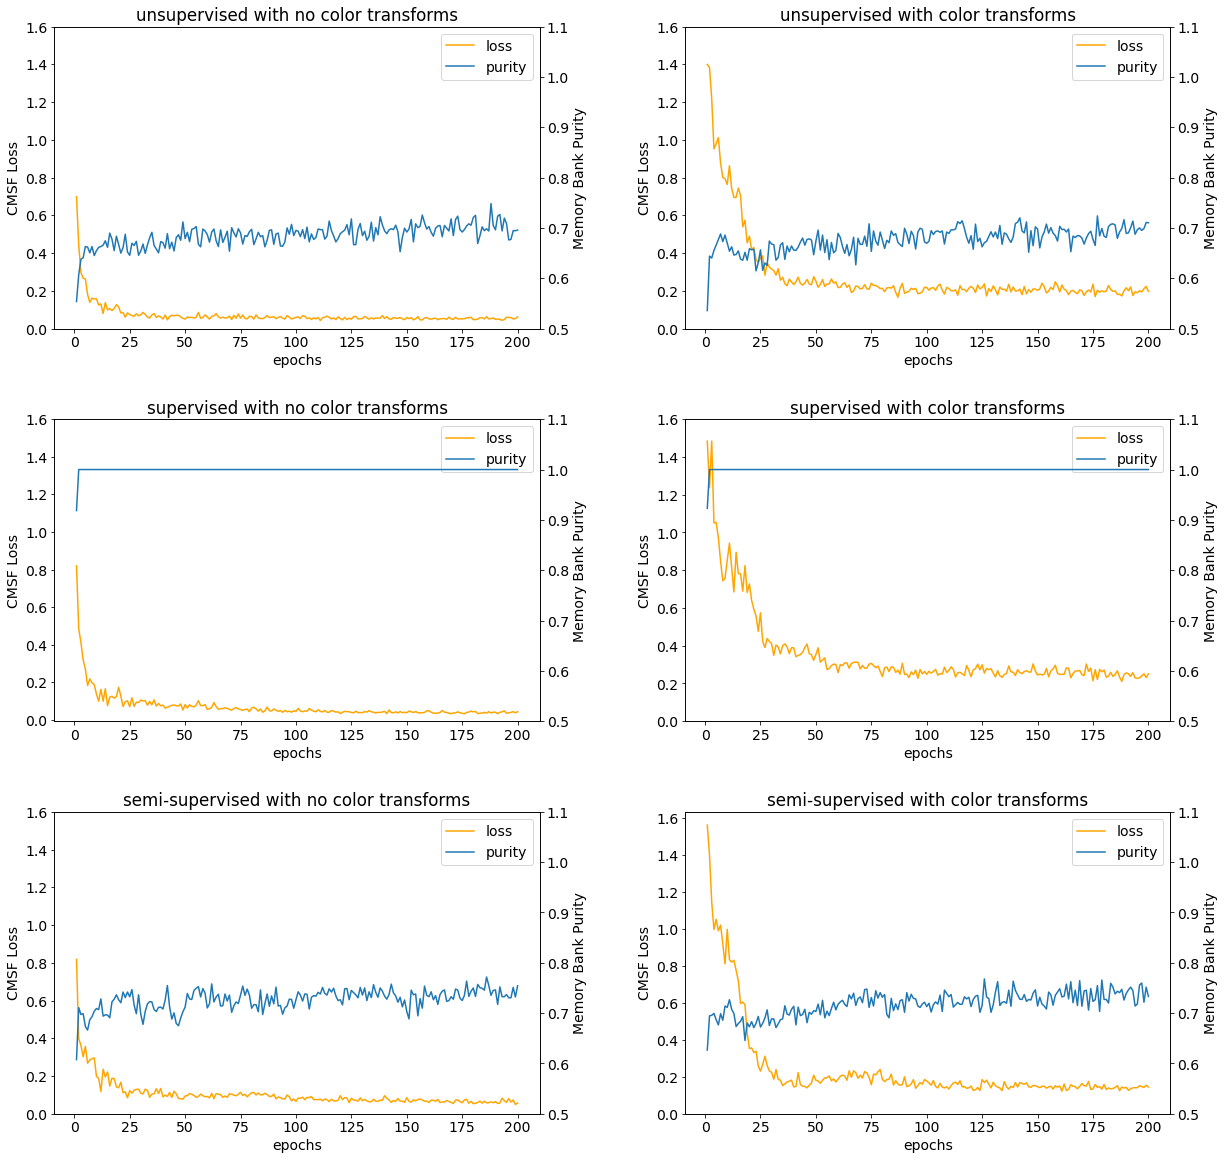

In [ ]:
mpl.rcParams['font.size'] = 14

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    history_df = ckpts[i]['history_df']
    p1, = ax.plot(history_df.index, history_df.loss, color='orange', label='loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('CMSF Loss')
    ax.set_yticks(np.arange(0, 1.7, 0.2))

    purity = history_df.purity if i < 2  else history_df.purity / 100
    t = ax.twinx()
    p2, = t.plot(history_df.index, purity, label='purity')
    t.set_ylabel('Memory Bank Purity')
    t.set_yticks(np.arange(0.5, 1.1, 0.1))

    ax.set_title(train_folder_names[i].split('_')[0] + ('-supervised' if i >= 4 else '') + ' with ' + ('no ' if i % 2 == 0 else '') + 'color transforms')
    ax.legend(handles=[p1, p2])
fig.subplots_adjust(wspace=0.3, hspace=0.3)
#fig.suptitle('CMSF Loss and Memory Bank Purity', fontsize=20)

### RISE

In [ ]:
# these control the models and which epochs we evaluate
best_epochs = [100, 160]
train_folder_names = ['semi_supervised_finals/1_ww/', 'semi_supervised_finals/2_ws/']
#best_epochs = [170, 190, 200, 200, 100, 160]
#train_folder_names = ['unsupervised_finals/1_ww/', 'unsupervised_finals/2_ws/', 'supervised_finals/1_ww/', 'supervised_finals/2_ws/', 'semi_supervised_finals/1_ww/', 'semi_supervised_finals/2_ws/']

In [ ]:
class_name = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

In [ ]:
def example(img, image_name, model_ind, ax, explainer, model, model_name):

    true_dist  = labels_df.loc[image_name].to_numpy()
    true_label = class_name[true_dist.argmax()]
    
    plt.axis('off')
    plt.subplot(ax)
    if (model_ind == -1):
        #plt.title('%s\nLabel: %s ' % (image_name, true_label))
        plt.title('Label: %s ' % (true_label))
        tensor_imshow(img[0])
    else:
        k = 0
        saliency = explainer(img.cuda()).cpu().numpy()
        p, c = torch.topk(model(img.cuda()), k=1)
        p, c = p[0], c[0]
        pred_dist  = model(img).squeeze().detach().cpu().numpy()
        pred_label = class_name[pred_dist.argmax()]

        plt.title(model_name + ('(weak)' if model_ind % 2 == 0 else '(weak-strong)') + '\n {:.2f}% {}'.format(100*p[k], class_name[c[k]]))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.02)

        # crop corners of saliency map
        crop_radius = 112
        circle_mask = np.zeros((224,224,4), dtype=np.float64)
        circle_mask[:, :, 3] = 1
        center = (circle_mask.shape[0] // 2, circle_mask.shape[1] // 2)
        circle_mask = cv2.circle(circle_mask, center, crop_radius, (1,1,1,0), -1)
        plt.imshow(circle_mask)

Generating filters: 100%|██████████| 6000/6000 [00:27<00:00, 221.29it/s]


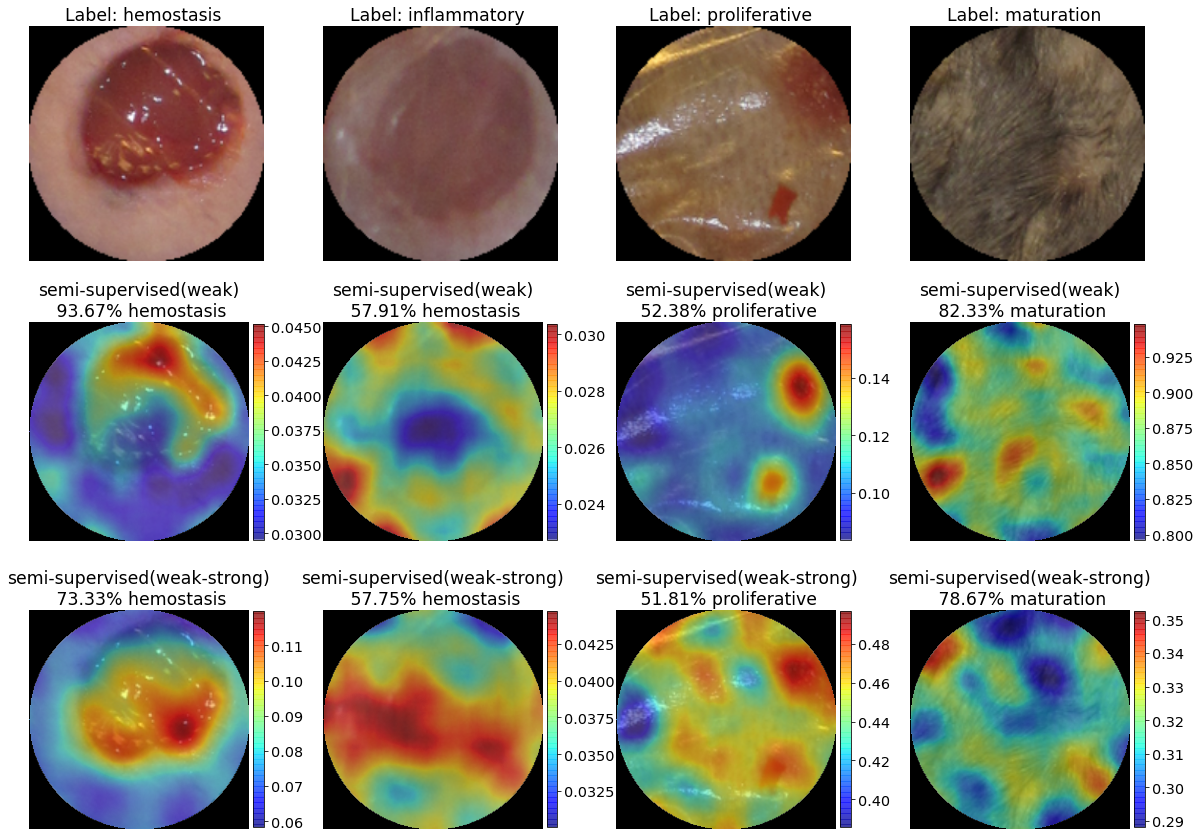

In [ ]:
test_images = ['Day 0_Y8-4-L.png', 'Day 4_A8-1-R.png', 'Day 12_A8-1-R.png', 'Day 11_Y8-4-L.png']
plt.rcParams.update({'font.size': 14.4})


n = len(train_folder_names)
m = len(test_images)

fig, axs = plt.subplots(n+1, m, figsize=(m*5, n*5+5))
fig.subplots_adjust(wspace=0.25)

for i in range(-1, n):
    if (i == -1):
        for j, image_name in enumerate(test_images):
            img_t = read_tensor(root_path + 'Circle_Cropped_images/' + image_name)
            example(img_t, image_name, i, axs[i+1,j], None, None, None)
    else:
        ckpt = torch.load(root_path + 'outputs/' + train_folder_names[i] + 'eval'+ eval_suffix + str(best_epochs[i]) + '/model_best.pth.tar')
        backbone = ckpt['backbone']
        linear = ckpt['linear']

        for p in backbone.parameters():
            p.requires_grad = False

        for p in linear.parameters():
            p.requires_grad = False

        model = lambda x: linear(backbone(x)).softmax(dim=1)
        model_name = train_folder_names[i].split('_')[0]
        model_name = (model_name + '-supervised') if model_name == 'semi' else model_name

        explainer = RISE(model, (224, 224), 250)
        explainer.generate_masks(N=6000, s=8, p1=0.1)

        for j, image_name in enumerate(test_images):
            img_t = read_tensor(root_path + 'Circle_Cropped_images/' + image_name)
            example(img_t, image_name, i, axs[i+1,j], explainer, model, model_name)

## Perturb Images

In [ ]:
# these control the models and which epochs we evaluate
best_epochs = [100, 160]
train_folder_names = ['semi_supervised_finals/1_ww/', 'semi_supervised_finals/2_ws/']
model_names = ['Semi-supervised weak', 'Semi-supervised weak-strong']

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])       
input_transf = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    normalize
])  

In [ ]:
def pred_perturb(img, transf, xs, plot_title, ax, model):
    hemos, infla, proli, matur = [], [], [], [] 
    for x in xs:
        img_p = transf(img, x)
        pred = model(input_transf(img_p).unsqueeze(0)).cpu().numpy()
        hemos.append(pred[0][0])
        infla.append(pred[0][1])
        proli.append(pred[0][2])
        matur.append(pred[0][3])
    
    ax.plot(xs, hemos, label='Hemostatis')
    ax.plot(xs, infla, label='Inflammatory')
    ax.plot(xs, proli, label='Proliferative')
    ax.plot(xs, matur, label='Maturation')
    ax.set_title(plot_title)
    ax.set_xlim(left=xs[0], right=xs[-1])
    ax.legend()

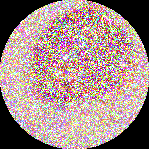

In [ ]:
def t(img, x):
    return TF.affine(img, translate=(int(x * 149), 0), angle=0, scale=1, shear=0) 

def crop_image(img):
    crop_radius = 75
    mask = np.zeros(img.shape, dtype=np.uint8)
    center = (mask.shape[0] // 2, mask.shape[1] // 2)
    mask = cv2.circle(mask, center, crop_radius, (255, 255, 255), -1)

    img = cv2.bitwise_and(img, mask)

    border = (img.shape[0] - (2 * crop_radius)) // 2 + 1
    img = img[border:border - 1 + 2 * crop_radius, border:border - 1 + 2 * crop_radius]

    return img

def noise(img_p, amount):
    img_np = np.asarray(img_p)
    img_np = random_noise(img_np, mode='salt', amount=amount)
    img_np = np.array(255*img_np, dtype='uint8')
    img_np = crop_image(img_np)
    return Image.fromarray(img_np)


test_images = ['Day 0_Y8-4-L.png', 'Day 11_Y8-4-L.png', 'Day 4_A8-1-R.png', 'Day 12_A8-1-R.png']
image_name = test_images[0]
img = Image.open(root_path + 'Circle_Cropped_images/' + image_name)
noise(img, 0.5)

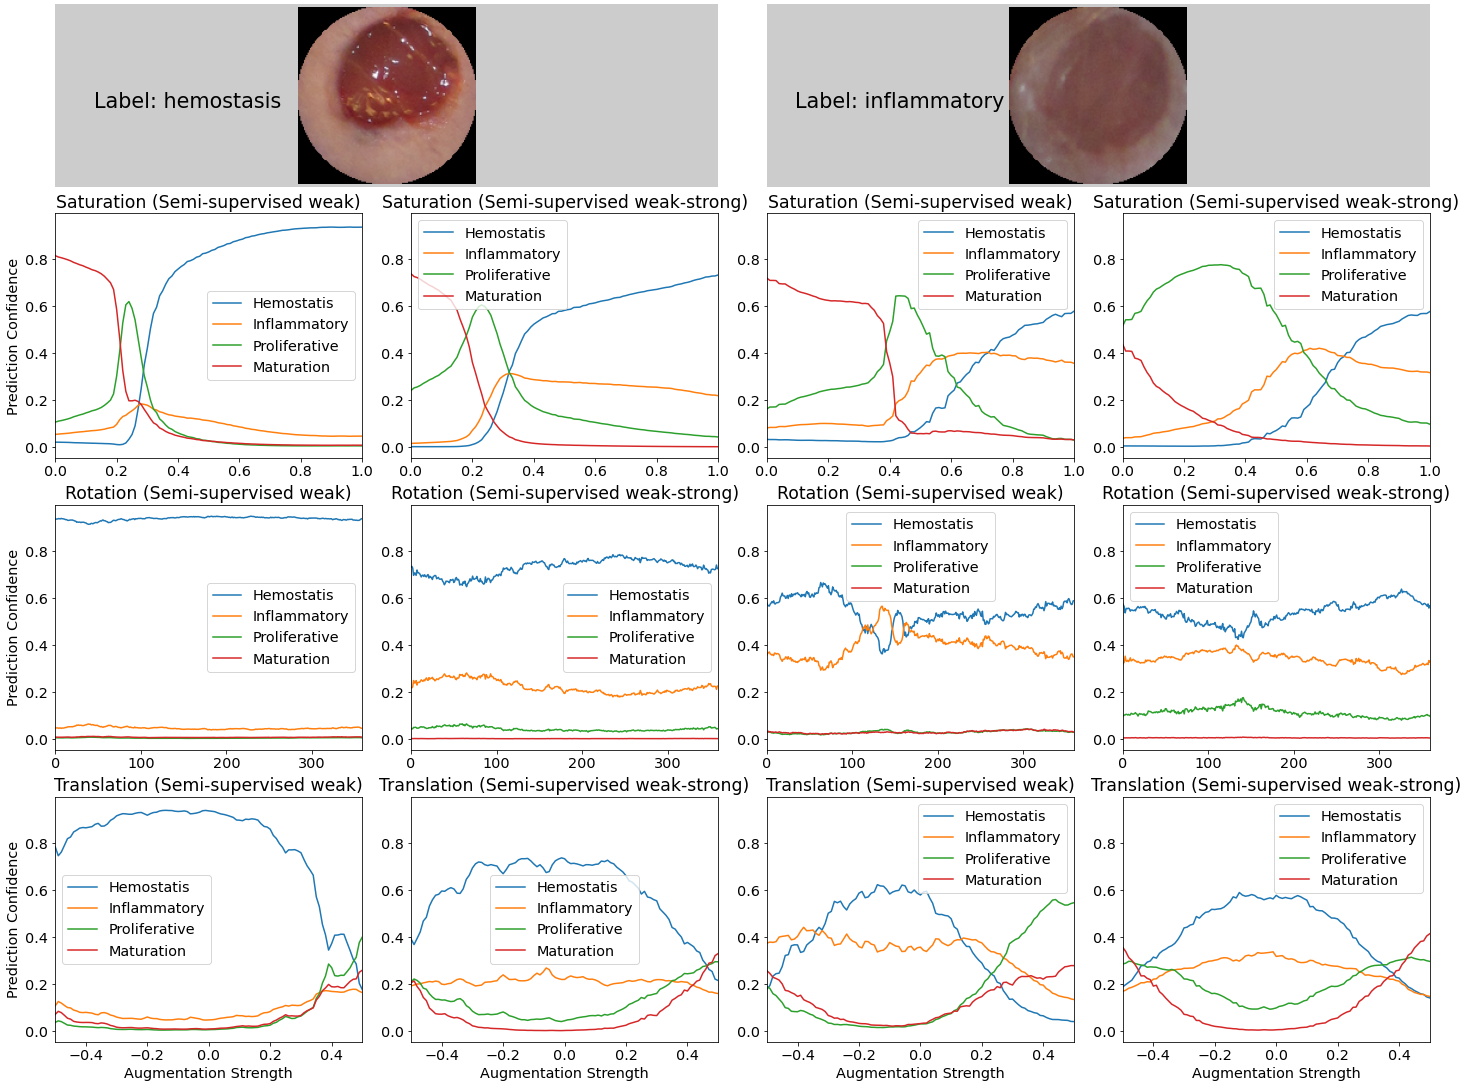

In [ ]:
titles = ['Saturation', 'Rotation', 'Translation']
xs = [np.array(range(0, 101)) / 100, list(range(0, 360)), np.array(range(-50, 51)) / 100]
transfs = [TF.adjust_saturation, TF.rotate, t]

test_images = ['Day 0_Y8-4-L.png','Day 4_A8-1-R.png',] #'Day 12_A8-1-R.png', 'Day 11_Y8-4-L.png', ]
#image_name = test_images[1]
imgs = [Image.open(root_path + 'Circle_Cropped_images/' + x) for x in test_images]

m = len(titles)
n = len(test_images)

plt.rcParams.update({'font.size': 14.4})
fig, axs = plt.subplots(m+1, 2*n, figsize=(10*n, m*4+3), constrained_layout=True, gridspec_kw={'height_ratios': [3] + [4] * m}, sharey=True)
gridspec = axs[0, 0].get_subplotspec().get_gridspec()
for a in axs[0, :]:
    a.remove()

for ax in axs.flatten():
    ax.yaxis.set_tick_params(labelleft=True)

for i in range(n):
    subfig = fig.add_subfigure(gridspec[0, (i*2):(i*2+2)])
    subfig.set_facecolor('0.8')
    ax = subfig.subplots(1, 1)
    ax.axis('off')
    ax.imshow(np.asarray(imgs[i]))
    class_name = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']
    true_dist  = labels_df.loc[test_images[i]].to_numpy()
    true_label = class_name[true_dist.argmax()]
    #ax.set_title('%s\nLabel: %s ' % (test_images[i], true_label), fontsize='x-large', y=0.4, x=-0.6)
    ax.set_title('Label: %s ' % (true_label), fontsize='x-large', y=0.4, x=-0.6)

for j in range(2):
    # load models
    ckpt = torch.load(root_path + 'outputs/' + train_folder_names[j]+ 'eval'+ eval_suffix + str(best_epochs[j]) + '/model_best.pth.tar')
    backbone = ckpt['backbone']
    linear = ckpt['linear']

    for p in backbone.parameters():
        p.requires_grad = False
    for p in linear.parameters():
        p.requires_grad = False

    model = lambda x: linear(backbone(x)).softmax(dim=1)

    for k in range(n):
        for i in range(m):
            plot_title = titles[i] + ' (' + model_names[j] + ')'
            pred_perturb(imgs[k], transfs[i], xs[i], plot_title, axs[i+1, j + 2*k], model)
            if i == m - 1:
                axs[i+1, j + 2*k].set_xlabel("Augmentation Strength")
            if j + 2*k == 0:
                axs[i+1, j + 2*k].set_ylabel("Prediction Confidence")